# What is Semantic Segmentation?
Semantic segmentation refers to the process of linking each pixel in an image to a class label. These labels could include a person, car, flower, piece of furniture, etc., just to mention a few.
We can think of semantic segmentation as image classification at a pixel level. For example, in an image that has many cars, segmentation will label all the objects as car objects. However, a separate class of models known as instance segmentation is able to label the separate instances where an object appears in an image. This kind of segmentation can be very useful in applications that are used to count the number of objects, such as counting the amount of foot traffic in a mall.

# Please upvote the kernel if you found it insightful!

# Import Libraries

In [1]:
# !pip install albumentations
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp


import torchvision
from torchvision import models
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocessing

In [2]:
IMAGE_PATH_1 = '../Denchik/dataСlass/oil'
IMAGE_PATH_0 = '../Denchik/dataСlass/clear/'
MASK_PATH = '../data2/Default/'

In [3]:
n_classes = 2



# Dataset

In [4]:
from tqdm.notebook import tqdm


def get_id_from_str(s):
    s = s.split(".")[0]
    return int(s[3:])

def ch_first(img):
    return np.moveaxis(img, -1, 0)

def ch_last(img):
    return np.moveaxis(img, 0, -1)


class DroneDataset(Dataset):
    
    def __init__(self, img_path_1, img_path_0, mask_path):
        self.img_path_0 = img_path_0
        self.img_path_1 = img_path_1
        self.mask_path = mask_path
        
        self.zero_img = os.listdir(self.img_path_0)[:200]
        zero_len = len(self.zero_img)
        
        self.mask_path_list = os.listdir(self.mask_path)[1:]
        # print(self.mask_path_list)
        self.id_list = [get_id_from_str(x) for x in self.mask_path_list] + [-1] * zero_len
        
        self.traintransform = transforms.Compose([
                transforms.RandomRotation((0, 360)),

                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
            ])
        
        
    def __len__(self):
        return len(self.id_list)
    
    def __getitem__(self, idx):
        id_ = self.id_list[idx]
        if id_ != -1:
            img_path = os.path.join(self.img_path_1, "img"+str(id_)+".npy")
            mask_path = os.path.join(self.mask_path, "img"+str(id_)+".npy.png")
        else:
            img = torch.from_numpy(ch_first(np.load(os.path.join(self.img_path_0, self.zero_img[idx - len(self.mask_path_list)])))).long()
            mask = torch.from_numpy(np.zeros((64, 64))).long()
            return img, mask
        
        img = np.load(img_path)
        mask = cv2.imread(mask_path)
        mask = mask[:, :, 2] != 0
        
        img, mask = torch.from_numpy(ch_first(img)).long(), torch.from_numpy(mask)
        
        img_mask = self.traintransform(torch.cat([img, mask.reshape(1, 64, 64)], dim=0))
        
        img, mask = img_mask[:-1], img_mask[-1]
        
        # print(img.shape)
        # print(mask.shape)
        
        return img, mask

In [5]:
from torch.utils.data.dataset import random_split
train_set = DroneDataset(IMAGE_PATH_1, IMAGE_PATH_0, MASK_PATH)
train, val = random_split(train_set, [len(train_set) - 50, 50])

In [6]:
# train_set[0]

In [7]:
len(train)

238

In [8]:
batch_size= 7

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=True)               

# Model

In [9]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=2, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])


In [10]:
# model.encoder.features[0][0].in_channels = 13
model.encoder.features[0][0] = torch.nn.Conv2d(13, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
# img, mask = next(iter(train_set))

# img = img.reshape(1, 13, 64, 64)
# out = model(img)

In [11]:
# plt.imshow(out[0][0].detach())

# mask.max()
# plt.imshow(mask)


# mask = cv2.imread("../data2/Default/img1161.npy.png")
# mask[:, :, 2] != 0

# Training

In [12]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [13]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.float().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [14]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(train_loader):
            #training phase
            image_tiles, mask_tiles = data
            
            image = image_tiles.to(device).float()
            mask = mask_tiles.to(device)
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            # iou_score += mIoU(output.long(), mask.long())
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data
                    
                    image = image_tiles.to(device).float()
                    mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    # val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

#             if (test_loss/len(val_loader)) > min_loss:
#                 not_improve += 1
#                 min_loss = (test_loss/len(val_loader))
#                 print(f'Loss Not Decrease for {not_improve} time')
#                 if not_improve == 7:
#                     print('Loss not decrease for 7 times, Stop Training')
#                     break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [15]:
max_lr = 1e-3
epoch = 1000
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 1.135 
Epoch:1/1000.. Train Loss: 1.199.. Val Loss: 1.135.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.284.. Val Acc:0.342.. Time: 0.12m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:2/1000.. Train Loss: 0.983.. Val Loss: 1.157.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.367.. Val Acc:0.451.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 1.135 >> 0.824 
Epoch:3/1000.. Train Loss: 0.872.. Val Loss: 0.824.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.468.. Val Acc:0.527.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 0.824 >> 0.687 
Epoch:4/1000.. Train Loss: 0.775.. Val Loss: 0.687.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.575.. Val Acc:0.595.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:5/1000.. Train Loss: 0.677.. Val Loss: 0.751.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.668.. Val Acc:0.658.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 0.687 >> 0.617 
saving model...
Epoch:6/1000.. Train Loss: 0.667.. Val Loss: 0.617.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.730.. Val Acc:0.749.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 0.617 >> 0.581 
Epoch:7/1000.. Train Loss: 0.590.. Val Loss: 0.581.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.786.. Val Acc:0.779.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 0.581 >> 0.560 
Epoch:8/1000.. Train Loss: 0.573.. Val Loss: 0.560.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.801.. Val Acc:0.768.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 0.560 >> 0.494 
Epoch:9/1000.. Train Loss: 0.523.. Val Loss: 0.494.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.826.. Val Acc:0.809.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:10/1000.. Train Loss: 0.490.. Val Loss: 0.662.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.844.. Val Acc:0.778.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 0.494 >> 0.485 
Epoch:11/1000.. Train Loss: 0.481.. Val Loss: 0.485.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.836.. Val Acc:0.830.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:12/1000.. Train Loss: 0.427.. Val Loss: 0.568.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.871.. Val Acc:0.749.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 0.485 >> 0.407 
saving model...
Epoch:13/1000.. Train Loss: 0.409.. Val Loss: 0.407.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.869.. Val Acc:0.845.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 0.407 >> 0.404 
Epoch:14/1000.. Train Loss: 0.396.. Val Loss: 0.404.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.864.. Val Acc:0.855.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:15/1000.. Train Loss: 0.362.. Val Loss: 0.431.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.879.. Val Acc:0.815.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:16/1000.. Train Loss: 0.349.. Val Loss: 0.433.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.878.. Val Acc:0.788.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:17/1000.. Train Loss: 0.349.. Val Loss: 0.425.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.871.. Val Acc:0.818.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 0.404 >> 0.361 
Epoch:18/1000.. Train Loss: 0.336.. Val Loss: 0.361.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.872.. Val Acc:0.840.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:19/1000.. Train Loss: 0.322.. Val Loss: 0.396.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.879.. Val Acc:0.843.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 0.361 >> 0.349 
Epoch:20/1000.. Train Loss: 0.310.. Val Loss: 0.349.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.880.. Val Acc:0.840.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:21/1000.. Train Loss: 0.334.. Val Loss: 0.420.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.849.. Val Acc:0.794.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:22/1000.. Train Loss: 0.308.. Val Loss: 0.360.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.871.. Val Acc:0.840.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 0.349 >> 0.318 
Epoch:23/1000.. Train Loss: 0.280.. Val Loss: 0.318.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.891.. Val Acc:0.849.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:24/1000.. Train Loss: 0.286.. Val Loss: 0.321.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.873.. Val Acc:0.852.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:25/1000.. Train Loss: 0.289.. Val Loss: 0.321.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.875.. Val Acc:0.846.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:26/1000.. Train Loss: 0.258.. Val Loss: 0.399.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.895.. Val Acc:0.805.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:27/1000.. Train Loss: 0.274.. Val Loss: 0.321.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.882.. Val Acc:0.851.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 0.318 >> 0.307 
saving model...
Epoch:28/1000.. Train Loss: 0.289.. Val Loss: 0.307.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.873.. Val Acc:0.857.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 0.307 >> 0.303 
Epoch:29/1000.. Train Loss: 0.257.. Val Loss: 0.303.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.881.. Val Acc:0.853.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:30/1000.. Train Loss: 0.260.. Val Loss: 0.324.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.881.. Val Acc:0.851.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 0.303 >> 0.303 
Epoch:31/1000.. Train Loss: 0.276.. Val Loss: 0.303.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.867.. Val Acc:0.853.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:32/1000.. Train Loss: 0.269.. Val Loss: 0.318.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.876.. Val Acc:0.853.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 0.303 >> 0.294 
Epoch:33/1000.. Train Loss: 0.242.. Val Loss: 0.294.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.889.. Val Acc:0.854.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 0.294 >> 0.267 
Epoch:34/1000.. Train Loss: 0.248.. Val Loss: 0.267.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.883.. Val Acc:0.861.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:35/1000.. Train Loss: 0.240.. Val Loss: 0.296.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.885.. Val Acc:0.845.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:36/1000.. Train Loss: 0.235.. Val Loss: 0.385.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.894.. Val Acc:0.820.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:37/1000.. Train Loss: 0.228.. Val Loss: 0.367.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.890.. Val Acc:0.815.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:38/1000.. Train Loss: 0.242.. Val Loss: 0.298.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.884.. Val Acc:0.839.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:39/1000.. Train Loss: 0.237.. Val Loss: 0.298.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.893.. Val Acc:0.837.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:40/1000.. Train Loss: 0.226.. Val Loss: 0.357.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.893.. Val Acc:0.795.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:41/1000.. Train Loss: 0.236.. Val Loss: 0.350.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.892.. Val Acc:0.816.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:42/1000.. Train Loss: 0.241.. Val Loss: 0.437.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.890.. Val Acc:0.805.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:43/1000.. Train Loss: 0.219.. Val Loss: 0.268.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.898.. Val Acc:0.863.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:44/1000.. Train Loss: 0.210.. Val Loss: 0.274.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.901.. Val Acc:0.862.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:45/1000.. Train Loss: 0.211.. Val Loss: 0.268.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.900.. Val Acc:0.856.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 0.267 >> 0.260 
saving model...
Epoch:46/1000.. Train Loss: 0.237.. Val Loss: 0.260.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.889.. Val Acc:0.868.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:47/1000.. Train Loss: 0.209.. Val Loss: 0.317.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.905.. Val Acc:0.842.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:48/1000.. Train Loss: 0.218.. Val Loss: 0.273.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.898.. Val Acc:0.852.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:49/1000.. Train Loss: 0.219.. Val Loss: 0.347.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.899.. Val Acc:0.829.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:50/1000.. Train Loss: 0.237.. Val Loss: 0.368.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.892.. Val Acc:0.789.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:51/1000.. Train Loss: 0.231.. Val Loss: 0.277.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.896.. Val Acc:0.861.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:52/1000.. Train Loss: 0.215.. Val Loss: 0.340.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.895.. Val Acc:0.823.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:53/1000.. Train Loss: 0.202.. Val Loss: 0.329.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.903.. Val Acc:0.822.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:54/1000.. Train Loss: 0.191.. Val Loss: 0.333.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.907.. Val Acc:0.817.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:55/1000.. Train Loss: 0.203.. Val Loss: 0.274.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.907.. Val Acc:0.851.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:56/1000.. Train Loss: 0.181.. Val Loss: 0.324.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.912.. Val Acc:0.841.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:57/1000.. Train Loss: 0.193.. Val Loss: 0.336.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.906.. Val Acc:0.803.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:58/1000.. Train Loss: 0.183.. Val Loss: 0.334.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.910.. Val Acc:0.814.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:59/1000.. Train Loss: 0.217.. Val Loss: 0.281.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.891.. Val Acc:0.861.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:60/1000.. Train Loss: 0.218.. Val Loss: 0.302.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.903.. Val Acc:0.857.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:61/1000.. Train Loss: 0.191.. Val Loss: 0.276.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.909.. Val Acc:0.854.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:62/1000.. Train Loss: 0.187.. Val Loss: 0.266.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.908.. Val Acc:0.860.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:63/1000.. Train Loss: 0.216.. Val Loss: 0.263.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.907.. Val Acc:0.847.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:64/1000.. Train Loss: 0.190.. Val Loss: 0.266.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.909.. Val Acc:0.858.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 0.260 >> 0.253 
Epoch:65/1000.. Train Loss: 0.199.. Val Loss: 0.253.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.900.. Val Acc:0.861.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:66/1000.. Train Loss: 0.218.. Val Loss: 0.314.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.897.. Val Acc:0.837.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:67/1000.. Train Loss: 0.198.. Val Loss: 0.336.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.899.. Val Acc:0.817.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 0.253 >> 0.237 
Epoch:68/1000.. Train Loss: 0.185.. Val Loss: 0.237.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.905.. Val Acc:0.863.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:69/1000.. Train Loss: 0.185.. Val Loss: 0.295.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.909.. Val Acc:0.841.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:70/1000.. Train Loss: 0.200.. Val Loss: 0.295.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.900.. Val Acc:0.829.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:71/1000.. Train Loss: 0.182.. Val Loss: 0.323.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.908.. Val Acc:0.814.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:72/1000.. Train Loss: 0.182.. Val Loss: 0.252.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.913.. Val Acc:0.867.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:73/1000.. Train Loss: 0.201.. Val Loss: 0.364.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.909.. Val Acc:0.793.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:74/1000.. Train Loss: 0.200.. Val Loss: 0.335.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.905.. Val Acc:0.809.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:75/1000.. Train Loss: 0.183.. Val Loss: 0.259.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.912.. Val Acc:0.854.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:76/1000.. Train Loss: 0.183.. Val Loss: 0.245.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.907.. Val Acc:0.860.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:77/1000.. Train Loss: 0.198.. Val Loss: 0.255.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.907.. Val Acc:0.862.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:78/1000.. Train Loss: 0.169.. Val Loss: 0.237.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.915.. Val Acc:0.870.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 0.237 >> 0.228 
Epoch:79/1000.. Train Loss: 0.170.. Val Loss: 0.228.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.917.. Val Acc:0.870.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:80/1000.. Train Loss: 0.181.. Val Loss: 0.442.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.911.. Val Acc:0.813.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:81/1000.. Train Loss: 0.211.. Val Loss: 0.274.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.897.. Val Acc:0.862.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:82/1000.. Train Loss: 0.242.. Val Loss: 0.257.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.902.. Val Acc:0.866.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:83/1000.. Train Loss: 0.226.. Val Loss: 0.320.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.900.. Val Acc:0.831.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:84/1000.. Train Loss: 0.198.. Val Loss: 0.309.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.904.. Val Acc:0.817.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:85/1000.. Train Loss: 0.179.. Val Loss: 0.304.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.913.. Val Acc:0.817.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:86/1000.. Train Loss: 0.187.. Val Loss: 0.256.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.912.. Val Acc:0.861.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:87/1000.. Train Loss: 0.171.. Val Loss: 0.252.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.913.. Val Acc:0.860.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:88/1000.. Train Loss: 0.169.. Val Loss: 0.241.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.914.. Val Acc:0.866.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:89/1000.. Train Loss: 0.183.. Val Loss: 0.313.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.909.. Val Acc:0.836.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:90/1000.. Train Loss: 0.178.. Val Loss: 0.245.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.911.. Val Acc:0.867.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:91/1000.. Train Loss: 0.167.. Val Loss: 0.301.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.917.. Val Acc:0.820.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:92/1000.. Train Loss: 0.187.. Val Loss: 0.330.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.913.. Val Acc:0.823.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:93/1000.. Train Loss: 0.233.. Val Loss: 0.309.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.895.. Val Acc:0.825.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:94/1000.. Train Loss: 0.181.. Val Loss: 0.264.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.908.. Val Acc:0.864.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:95/1000.. Train Loss: 0.164.. Val Loss: 0.237.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.917.. Val Acc:0.869.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:96/1000.. Train Loss: 0.176.. Val Loss: 0.229.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.914.. Val Acc:0.876.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:97/1000.. Train Loss: 0.180.. Val Loss: 0.228.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.914.. Val Acc:0.872.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:98/1000.. Train Loss: 0.171.. Val Loss: 0.238.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.914.. Val Acc:0.867.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:99/1000.. Train Loss: 0.168.. Val Loss: 0.238.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.913.. Val Acc:0.866.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:100/1000.. Train Loss: 0.163.. Val Loss: 0.247.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.916.. Val Acc:0.870.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:101/1000.. Train Loss: 0.165.. Val Loss: 0.248.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.915.. Val Acc:0.868.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:102/1000.. Train Loss: 0.165.. Val Loss: 0.277.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.915.. Val Acc:0.849.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:103/1000.. Train Loss: 0.177.. Val Loss: 0.335.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.915.. Val Acc:0.814.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:104/1000.. Train Loss: 0.194.. Val Loss: 0.245.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.912.. Val Acc:0.867.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:105/1000.. Train Loss: 0.165.. Val Loss: 0.306.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.920.. Val Acc:0.842.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:106/1000.. Train Loss: 0.179.. Val Loss: 0.264.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.906.. Val Acc:0.849.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:107/1000.. Train Loss: 0.197.. Val Loss: 0.328.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.909.. Val Acc:0.809.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:108/1000.. Train Loss: 0.170.. Val Loss: 0.235.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.916.. Val Acc:0.867.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:109/1000.. Train Loss: 0.166.. Val Loss: 0.378.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.918.. Val Acc:0.810.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:110/1000.. Train Loss: 0.178.. Val Loss: 0.319.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.918.. Val Acc:0.824.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:111/1000.. Train Loss: 0.178.. Val Loss: 0.242.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.915.. Val Acc:0.871.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:112/1000.. Train Loss: 0.192.. Val Loss: 0.360.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.903.. Val Acc:0.804.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:113/1000.. Train Loss: 0.187.. Val Loss: 0.254.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.903.. Val Acc:0.864.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:114/1000.. Train Loss: 0.171.. Val Loss: 0.290.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.917.. Val Acc:0.856.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:115/1000.. Train Loss: 0.174.. Val Loss: 0.243.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.913.. Val Acc:0.867.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:116/1000.. Train Loss: 0.185.. Val Loss: 0.260.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.912.. Val Acc:0.865.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:117/1000.. Train Loss: 0.169.. Val Loss: 0.249.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.919.. Val Acc:0.868.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:118/1000.. Train Loss: 0.189.. Val Loss: 0.239.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.909.. Val Acc:0.868.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:119/1000.. Train Loss: 0.179.. Val Loss: 0.339.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.914.. Val Acc:0.802.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:120/1000.. Train Loss: 0.170.. Val Loss: 0.244.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.915.. Val Acc:0.862.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:121/1000.. Train Loss: 0.205.. Val Loss: 0.274.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.910.. Val Acc:0.857.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:122/1000.. Train Loss: 0.162.. Val Loss: 0.306.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.917.. Val Acc:0.811.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:123/1000.. Train Loss: 0.169.. Val Loss: 0.238.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.918.. Val Acc:0.866.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:124/1000.. Train Loss: 0.161.. Val Loss: 0.348.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.921.. Val Acc:0.825.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:125/1000.. Train Loss: 0.173.. Val Loss: 0.306.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.915.. Val Acc:0.819.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:126/1000.. Train Loss: 0.167.. Val Loss: 0.244.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.921.. Val Acc:0.869.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:127/1000.. Train Loss: 0.166.. Val Loss: 0.324.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.915.. Val Acc:0.813.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:128/1000.. Train Loss: 0.172.. Val Loss: 0.370.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.911.. Val Acc:0.803.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:129/1000.. Train Loss: 0.181.. Val Loss: 0.246.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.910.. Val Acc:0.861.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:130/1000.. Train Loss: 0.180.. Val Loss: 0.237.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.911.. Val Acc:0.863.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 0.228 >> 0.227 
Epoch:131/1000.. Train Loss: 0.160.. Val Loss: 0.227.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.918.. Val Acc:0.870.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:132/1000.. Train Loss: 0.175.. Val Loss: 0.250.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.915.. Val Acc:0.855.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:133/1000.. Train Loss: 0.169.. Val Loss: 0.251.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.914.. Val Acc:0.859.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:134/1000.. Train Loss: 0.163.. Val Loss: 0.270.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.916.. Val Acc:0.849.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:135/1000.. Train Loss: 0.161.. Val Loss: 0.285.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.913.. Val Acc:0.855.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:136/1000.. Train Loss: 0.168.. Val Loss: 0.307.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.917.. Val Acc:0.822.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:137/1000.. Train Loss: 0.179.. Val Loss: 0.230.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.916.. Val Acc:0.871.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:138/1000.. Train Loss: 0.169.. Val Loss: 0.245.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.914.. Val Acc:0.870.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:139/1000.. Train Loss: 0.187.. Val Loss: 0.257.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.909.. Val Acc:0.863.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:140/1000.. Train Loss: 0.200.. Val Loss: 0.233.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.905.. Val Acc:0.868.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:141/1000.. Train Loss: 0.168.. Val Loss: 0.318.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.915.. Val Acc:0.823.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:142/1000.. Train Loss: 0.157.. Val Loss: 0.250.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.920.. Val Acc:0.867.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:143/1000.. Train Loss: 0.155.. Val Loss: 0.300.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.919.. Val Acc:0.815.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:144/1000.. Train Loss: 0.233.. Val Loss: 0.249.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.912.. Val Acc:0.865.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:145/1000.. Train Loss: 0.159.. Val Loss: 0.243.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.920.. Val Acc:0.864.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:146/1000.. Train Loss: 0.188.. Val Loss: 0.489.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.901.. Val Acc:0.766.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:147/1000.. Train Loss: 0.221.. Val Loss: 0.273.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.888.. Val Acc:0.849.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:148/1000.. Train Loss: 0.189.. Val Loss: 0.240.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.904.. Val Acc:0.852.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:149/1000.. Train Loss: 0.175.. Val Loss: 0.250.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.911.. Val Acc:0.866.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:150/1000.. Train Loss: 0.167.. Val Loss: 0.244.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.914.. Val Acc:0.856.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:151/1000.. Train Loss: 0.163.. Val Loss: 0.297.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.920.. Val Acc:0.845.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:152/1000.. Train Loss: 0.163.. Val Loss: 0.264.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.917.. Val Acc:0.863.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:153/1000.. Train Loss: 0.161.. Val Loss: 0.256.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.919.. Val Acc:0.858.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:154/1000.. Train Loss: 0.159.. Val Loss: 0.240.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.916.. Val Acc:0.865.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:155/1000.. Train Loss: 0.156.. Val Loss: 0.264.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.921.. Val Acc:0.867.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:156/1000.. Train Loss: 0.152.. Val Loss: 0.235.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.922.. Val Acc:0.867.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:157/1000.. Train Loss: 0.160.. Val Loss: 0.295.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.919.. Val Acc:0.822.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:158/1000.. Train Loss: 0.153.. Val Loss: 0.228.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.923.. Val Acc:0.872.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:159/1000.. Train Loss: 0.153.. Val Loss: 0.232.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.920.. Val Acc:0.872.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:160/1000.. Train Loss: 0.157.. Val Loss: 0.309.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.924.. Val Acc:0.848.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:161/1000.. Train Loss: 0.193.. Val Loss: 0.301.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.906.. Val Acc:0.832.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:162/1000.. Train Loss: 0.159.. Val Loss: 0.227.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.918.. Val Acc:0.872.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:163/1000.. Train Loss: 0.156.. Val Loss: 0.242.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.918.. Val Acc:0.856.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:164/1000.. Train Loss: 0.177.. Val Loss: 0.246.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.915.. Val Acc:0.856.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:165/1000.. Train Loss: 0.154.. Val Loss: 0.245.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.923.. Val Acc:0.872.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:166/1000.. Train Loss: 0.152.. Val Loss: 0.333.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.922.. Val Acc:0.820.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:167/1000.. Train Loss: 0.163.. Val Loss: 0.366.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.920.. Val Acc:0.812.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:168/1000.. Train Loss: 0.149.. Val Loss: 0.316.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.924.. Val Acc:0.820.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:169/1000.. Train Loss: 0.163.. Val Loss: 0.268.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.922.. Val Acc:0.872.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:170/1000.. Train Loss: 0.192.. Val Loss: 0.251.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.907.. Val Acc:0.866.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:171/1000.. Train Loss: 0.169.. Val Loss: 0.292.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.920.. Val Acc:0.827.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:172/1000.. Train Loss: 0.164.. Val Loss: 0.240.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.921.. Val Acc:0.859.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:173/1000.. Train Loss: 0.160.. Val Loss: 0.255.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.918.. Val Acc:0.867.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:174/1000.. Train Loss: 0.202.. Val Loss: 0.242.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.891.. Val Acc:0.865.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:175/1000.. Train Loss: 0.223.. Val Loss: 0.232.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.887.. Val Acc:0.873.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:176/1000.. Train Loss: 0.227.. Val Loss: 0.232.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.884.. Val Acc:0.871.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 0.227 >> 0.218 
saving model...
Epoch:177/1000.. Train Loss: 0.161.. Val Loss: 0.218.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.918.. Val Acc:0.873.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:178/1000.. Train Loss: 0.158.. Val Loss: 0.317.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.919.. Val Acc:0.860.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:179/1000.. Train Loss: 0.153.. Val Loss: 0.236.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.921.. Val Acc:0.870.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:180/1000.. Train Loss: 0.156.. Val Loss: 0.227.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.920.. Val Acc:0.868.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:181/1000.. Train Loss: 0.165.. Val Loss: 0.327.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.921.. Val Acc:0.804.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:182/1000.. Train Loss: 0.158.. Val Loss: 0.312.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.923.. Val Acc:0.820.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:183/1000.. Train Loss: 0.190.. Val Loss: 0.422.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.901.. Val Acc:0.845.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:184/1000.. Train Loss: 0.302.. Val Loss: 0.358.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.850.. Val Acc:0.823.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:185/1000.. Train Loss: 0.205.. Val Loss: 0.240.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.882.. Val Acc:0.861.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:186/1000.. Train Loss: 0.234.. Val Loss: 0.336.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.888.. Val Acc:0.800.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:187/1000.. Train Loss: 0.239.. Val Loss: 0.325.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.884.. Val Acc:0.820.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:188/1000.. Train Loss: 0.198.. Val Loss: 0.299.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.900.. Val Acc:0.826.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:189/1000.. Train Loss: 0.163.. Val Loss: 0.238.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.918.. Val Acc:0.871.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:190/1000.. Train Loss: 0.175.. Val Loss: 0.438.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.909.. Val Acc:0.733.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:191/1000.. Train Loss: 0.182.. Val Loss: 0.225.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.901.. Val Acc:0.869.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:192/1000.. Train Loss: 0.218.. Val Loss: 0.306.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.910.. Val Acc:0.845.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:193/1000.. Train Loss: 0.189.. Val Loss: 0.234.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.911.. Val Acc:0.869.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:194/1000.. Train Loss: 0.163.. Val Loss: 0.221.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.915.. Val Acc:0.873.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:195/1000.. Train Loss: 0.161.. Val Loss: 0.281.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.916.. Val Acc:0.852.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:196/1000.. Train Loss: 0.199.. Val Loss: 0.309.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.906.. Val Acc:0.840.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:197/1000.. Train Loss: 0.184.. Val Loss: 0.241.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.904.. Val Acc:0.865.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:198/1000.. Train Loss: 0.167.. Val Loss: 0.223.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.916.. Val Acc:0.868.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:199/1000.. Train Loss: 0.174.. Val Loss: 0.327.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.914.. Val Acc:0.821.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:200/1000.. Train Loss: 0.173.. Val Loss: 0.228.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.913.. Val Acc:0.871.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:201/1000.. Train Loss: 0.158.. Val Loss: 0.221.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.918.. Val Acc:0.874.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:202/1000.. Train Loss: 0.173.. Val Loss: 0.328.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.915.. Val Acc:0.812.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:203/1000.. Train Loss: 0.161.. Val Loss: 0.245.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.920.. Val Acc:0.862.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:204/1000.. Train Loss: 0.201.. Val Loss: 0.353.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.900.. Val Acc:0.800.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:205/1000.. Train Loss: 0.169.. Val Loss: 0.276.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.919.. Val Acc:0.874.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:206/1000.. Train Loss: 0.176.. Val Loss: 0.238.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.914.. Val Acc:0.868.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:207/1000.. Train Loss: 0.158.. Val Loss: 0.275.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.915.. Val Acc:0.866.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:208/1000.. Train Loss: 0.168.. Val Loss: 0.302.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.920.. Val Acc:0.832.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:209/1000.. Train Loss: 0.157.. Val Loss: 0.227.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.920.. Val Acc:0.872.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:210/1000.. Train Loss: 0.172.. Val Loss: 0.293.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.910.. Val Acc:0.844.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:211/1000.. Train Loss: 0.189.. Val Loss: 0.291.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.911.. Val Acc:0.857.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:212/1000.. Train Loss: 0.174.. Val Loss: 0.283.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.915.. Val Acc:0.837.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:213/1000.. Train Loss: 0.162.. Val Loss: 0.287.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.912.. Val Acc:0.826.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:214/1000.. Train Loss: 0.160.. Val Loss: 0.237.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.918.. Val Acc:0.866.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:215/1000.. Train Loss: 0.158.. Val Loss: 0.299.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.917.. Val Acc:0.827.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:216/1000.. Train Loss: 0.149.. Val Loss: 0.368.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.923.. Val Acc:0.806.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:217/1000.. Train Loss: 0.162.. Val Loss: 0.239.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.921.. Val Acc:0.870.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:218/1000.. Train Loss: 0.155.. Val Loss: 0.246.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.921.. Val Acc:0.871.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:219/1000.. Train Loss: 0.169.. Val Loss: 0.317.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.920.. Val Acc:0.820.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:220/1000.. Train Loss: 0.160.. Val Loss: 0.313.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.919.. Val Acc:0.841.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:221/1000.. Train Loss: 0.152.. Val Loss: 0.234.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.921.. Val Acc:0.870.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:222/1000.. Train Loss: 0.159.. Val Loss: 0.248.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.920.. Val Acc:0.872.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:223/1000.. Train Loss: 0.160.. Val Loss: 0.568.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.921.. Val Acc:0.811.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:224/1000.. Train Loss: 0.155.. Val Loss: 0.248.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.918.. Val Acc:0.871.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:225/1000.. Train Loss: 0.152.. Val Loss: 0.329.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.922.. Val Acc:0.808.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:226/1000.. Train Loss: 0.168.. Val Loss: 0.292.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.921.. Val Acc:0.848.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:227/1000.. Train Loss: 0.165.. Val Loss: 0.325.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.916.. Val Acc:0.821.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:228/1000.. Train Loss: 0.151.. Val Loss: 0.329.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.925.. Val Acc:0.827.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:229/1000.. Train Loss: 0.152.. Val Loss: 0.229.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.921.. Val Acc:0.872.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:230/1000.. Train Loss: 0.147.. Val Loss: 0.233.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.927.. Val Acc:0.871.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:231/1000.. Train Loss: 0.147.. Val Loss: 0.223.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.873.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:232/1000.. Train Loss: 0.152.. Val Loss: 0.247.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.923.. Val Acc:0.870.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:233/1000.. Train Loss: 0.166.. Val Loss: 0.222.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.917.. Val Acc:0.870.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:234/1000.. Train Loss: 0.159.. Val Loss: 0.247.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.919.. Val Acc:0.856.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:235/1000.. Train Loss: 0.199.. Val Loss: 0.358.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.910.. Val Acc:0.799.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:236/1000.. Train Loss: 0.245.. Val Loss: 0.242.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.872.. Val Acc:0.870.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:237/1000.. Train Loss: 0.216.. Val Loss: 0.296.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.896.. Val Acc:0.825.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:238/1000.. Train Loss: 0.191.. Val Loss: 0.308.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.909.. Val Acc:0.829.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:239/1000.. Train Loss: 0.185.. Val Loss: 0.229.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.903.. Val Acc:0.874.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:240/1000.. Train Loss: 0.175.. Val Loss: 0.234.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.912.. Val Acc:0.872.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:241/1000.. Train Loss: 0.170.. Val Loss: 0.257.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.916.. Val Acc:0.870.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:242/1000.. Train Loss: 0.162.. Val Loss: 0.268.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.918.. Val Acc:0.868.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:243/1000.. Train Loss: 0.184.. Val Loss: 0.289.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.901.. Val Acc:0.823.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:244/1000.. Train Loss: 0.167.. Val Loss: 0.291.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.919.. Val Acc:0.833.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:245/1000.. Train Loss: 0.186.. Val Loss: 0.234.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.914.. Val Acc:0.870.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:246/1000.. Train Loss: 0.169.. Val Loss: 0.229.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.918.. Val Acc:0.872.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:247/1000.. Train Loss: 0.164.. Val Loss: 0.230.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.920.. Val Acc:0.868.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:248/1000.. Train Loss: 0.161.. Val Loss: 0.230.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.919.. Val Acc:0.868.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:249/1000.. Train Loss: 0.176.. Val Loss: 0.263.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.909.. Val Acc:0.862.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:250/1000.. Train Loss: 0.166.. Val Loss: 0.310.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.915.. Val Acc:0.822.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:251/1000.. Train Loss: 0.168.. Val Loss: 0.230.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.916.. Val Acc:0.871.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Loss Decreasing.. 0.218 >> 0.214 
Epoch:252/1000.. Train Loss: 0.158.. Val Loss: 0.214.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.917.. Val Acc:0.878.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:253/1000.. Train Loss: 0.154.. Val Loss: 0.219.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.920.. Val Acc:0.875.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:254/1000.. Train Loss: 0.245.. Val Loss: 0.299.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.885.. Val Acc:0.830.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:255/1000.. Train Loss: 0.213.. Val Loss: 0.256.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.890.. Val Acc:0.869.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:256/1000.. Train Loss: 0.179.. Val Loss: 0.245.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.904.. Val Acc:0.864.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:257/1000.. Train Loss: 0.235.. Val Loss: 0.301.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.885.. Val Acc:0.834.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:258/1000.. Train Loss: 0.172.. Val Loss: 0.236.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.908.. Val Acc:0.866.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:259/1000.. Train Loss: 0.184.. Val Loss: 0.302.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.912.. Val Acc:0.813.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:260/1000.. Train Loss: 0.161.. Val Loss: 0.316.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.919.. Val Acc:0.815.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:261/1000.. Train Loss: 0.159.. Val Loss: 0.268.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.919.. Val Acc:0.858.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:262/1000.. Train Loss: 0.164.. Val Loss: 0.279.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.918.. Val Acc:0.853.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:263/1000.. Train Loss: 0.166.. Val Loss: 0.227.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.914.. Val Acc:0.870.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:264/1000.. Train Loss: 0.162.. Val Loss: 0.303.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.918.. Val Acc:0.833.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:265/1000.. Train Loss: 0.167.. Val Loss: 0.318.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.920.. Val Acc:0.800.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:266/1000.. Train Loss: 0.157.. Val Loss: 0.221.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.918.. Val Acc:0.873.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:267/1000.. Train Loss: 0.154.. Val Loss: 0.226.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.920.. Val Acc:0.872.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:268/1000.. Train Loss: 0.184.. Val Loss: 0.237.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.920.. Val Acc:0.869.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:269/1000.. Train Loss: 0.171.. Val Loss: 0.228.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.912.. Val Acc:0.871.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:270/1000.. Train Loss: 0.164.. Val Loss: 0.227.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.914.. Val Acc:0.872.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:271/1000.. Train Loss: 0.165.. Val Loss: 0.311.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.916.. Val Acc:0.828.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:272/1000.. Train Loss: 0.165.. Val Loss: 0.347.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.917.. Val Acc:0.824.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:273/1000.. Train Loss: 0.156.. Val Loss: 0.246.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.921.. Val Acc:0.871.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:274/1000.. Train Loss: 0.163.. Val Loss: 0.298.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.919.. Val Acc:0.824.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:275/1000.. Train Loss: 0.157.. Val Loss: 0.255.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.921.. Val Acc:0.869.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:276/1000.. Train Loss: 0.198.. Val Loss: 0.297.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.895.. Val Acc:0.832.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:277/1000.. Train Loss: 0.169.. Val Loss: 0.230.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.919.. Val Acc:0.872.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:278/1000.. Train Loss: 0.159.. Val Loss: 0.293.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.919.. Val Acc:0.849.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:279/1000.. Train Loss: 0.155.. Val Loss: 0.314.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.922.. Val Acc:0.807.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:280/1000.. Train Loss: 0.154.. Val Loss: 0.261.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.920.. Val Acc:0.863.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:281/1000.. Train Loss: 0.182.. Val Loss: 0.298.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.920.. Val Acc:0.835.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:282/1000.. Train Loss: 0.157.. Val Loss: 0.232.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.918.. Val Acc:0.865.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:283/1000.. Train Loss: 0.149.. Val Loss: 0.236.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.921.. Val Acc:0.869.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:284/1000.. Train Loss: 0.168.. Val Loss: 0.328.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.919.. Val Acc:0.811.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:285/1000.. Train Loss: 0.154.. Val Loss: 0.321.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.919.. Val Acc:0.820.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:286/1000.. Train Loss: 0.157.. Val Loss: 0.245.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.919.. Val Acc:0.870.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:287/1000.. Train Loss: 0.153.. Val Loss: 0.257.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.923.. Val Acc:0.863.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:288/1000.. Train Loss: 0.163.. Val Loss: 0.425.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.914.. Val Acc:0.807.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:289/1000.. Train Loss: 0.154.. Val Loss: 0.235.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.918.. Val Acc:0.868.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:290/1000.. Train Loss: 0.151.. Val Loss: 0.230.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.921.. Val Acc:0.870.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:291/1000.. Train Loss: 0.153.. Val Loss: 0.320.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.919.. Val Acc:0.861.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:292/1000.. Train Loss: 0.152.. Val Loss: 0.293.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.918.. Val Acc:0.839.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:293/1000.. Train Loss: 0.151.. Val Loss: 0.232.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.922.. Val Acc:0.873.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:294/1000.. Train Loss: 0.152.. Val Loss: 0.340.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.922.. Val Acc:0.833.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:295/1000.. Train Loss: 0.152.. Val Loss: 0.260.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.922.. Val Acc:0.872.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:296/1000.. Train Loss: 0.169.. Val Loss: 0.309.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.911.. Val Acc:0.831.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:297/1000.. Train Loss: 0.161.. Val Loss: 0.231.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.921.. Val Acc:0.874.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:298/1000.. Train Loss: 0.155.. Val Loss: 0.229.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.919.. Val Acc:0.870.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:299/1000.. Train Loss: 0.147.. Val Loss: 0.228.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.924.. Val Acc:0.870.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:300/1000.. Train Loss: 0.149.. Val Loss: 0.233.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.923.. Val Acc:0.869.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:301/1000.. Train Loss: 0.146.. Val Loss: 0.314.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.924.. Val Acc:0.817.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:302/1000.. Train Loss: 0.149.. Val Loss: 0.237.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.923.. Val Acc:0.866.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:303/1000.. Train Loss: 0.146.. Val Loss: 0.238.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.925.. Val Acc:0.870.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:304/1000.. Train Loss: 0.156.. Val Loss: 0.381.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.924.. Val Acc:0.835.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:305/1000.. Train Loss: 0.157.. Val Loss: 0.296.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.921.. Val Acc:0.854.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:306/1000.. Train Loss: 0.170.. Val Loss: 0.239.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.915.. Val Acc:0.878.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:307/1000.. Train Loss: 0.230.. Val Loss: 0.296.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.893.. Val Acc:0.843.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:308/1000.. Train Loss: 0.170.. Val Loss: 0.291.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.917.. Val Acc:0.833.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:309/1000.. Train Loss: 0.184.. Val Loss: 0.284.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.916.. Val Acc:0.840.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:310/1000.. Train Loss: 0.181.. Val Loss: 0.241.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.906.. Val Acc:0.869.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:311/1000.. Train Loss: 0.189.. Val Loss: 0.270.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.909.. Val Acc:0.858.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:312/1000.. Train Loss: 0.157.. Val Loss: 0.223.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.919.. Val Acc:0.872.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:313/1000.. Train Loss: 0.165.. Val Loss: 0.231.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.921.. Val Acc:0.873.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:314/1000.. Train Loss: 0.153.. Val Loss: 0.294.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.921.. Val Acc:0.846.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:315/1000.. Train Loss: 0.150.. Val Loss: 0.323.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.924.. Val Acc:0.816.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:316/1000.. Train Loss: 0.151.. Val Loss: 0.223.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.922.. Val Acc:0.875.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:317/1000.. Train Loss: 0.151.. Val Loss: 0.267.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.923.. Val Acc:0.864.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:318/1000.. Train Loss: 0.153.. Val Loss: 0.275.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.919.. Val Acc:0.856.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:319/1000.. Train Loss: 0.176.. Val Loss: 0.387.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.908.. Val Acc:0.815.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:320/1000.. Train Loss: 0.160.. Val Loss: 0.314.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.919.. Val Acc:0.848.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:321/1000.. Train Loss: 0.151.. Val Loss: 0.304.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.921.. Val Acc:0.824.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:322/1000.. Train Loss: 0.224.. Val Loss: 0.381.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.915.. Val Acc:0.820.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:323/1000.. Train Loss: 0.276.. Val Loss: 0.335.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.862.. Val Acc:0.840.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:324/1000.. Train Loss: 0.252.. Val Loss: 0.238.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.879.. Val Acc:0.868.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:325/1000.. Train Loss: 0.190.. Val Loss: 0.233.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.909.. Val Acc:0.870.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:326/1000.. Train Loss: 0.166.. Val Loss: 0.233.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.914.. Val Acc:0.864.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:327/1000.. Train Loss: 0.165.. Val Loss: 0.271.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.919.. Val Acc:0.871.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:328/1000.. Train Loss: 0.157.. Val Loss: 0.291.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.921.. Val Acc:0.845.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:329/1000.. Train Loss: 0.153.. Val Loss: 0.341.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.921.. Val Acc:0.838.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:330/1000.. Train Loss: 0.178.. Val Loss: 0.262.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.909.. Val Acc:0.865.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:331/1000.. Train Loss: 0.222.. Val Loss: 0.358.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.901.. Val Acc:0.807.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:332/1000.. Train Loss: 0.201.. Val Loss: 0.331.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.906.. Val Acc:0.835.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:333/1000.. Train Loss: 0.176.. Val Loss: 0.242.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.918.. Val Acc:0.871.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:334/1000.. Train Loss: 0.161.. Val Loss: 0.233.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.920.. Val Acc:0.871.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:335/1000.. Train Loss: 0.170.. Val Loss: 0.251.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.921.. Val Acc:0.863.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:336/1000.. Train Loss: 0.166.. Val Loss: 0.307.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.918.. Val Acc:0.829.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:337/1000.. Train Loss: 0.183.. Val Loss: 0.256.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.918.. Val Acc:0.869.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:338/1000.. Train Loss: 0.188.. Val Loss: 0.327.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.919.. Val Acc:0.814.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:339/1000.. Train Loss: 0.163.. Val Loss: 0.325.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.919.. Val Acc:0.835.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:340/1000.. Train Loss: 0.155.. Val Loss: 0.234.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.919.. Val Acc:0.874.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:341/1000.. Train Loss: 0.148.. Val Loss: 0.261.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.869.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:342/1000.. Train Loss: 0.151.. Val Loss: 0.302.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.924.. Val Acc:0.832.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:343/1000.. Train Loss: 0.157.. Val Loss: 0.238.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.919.. Val Acc:0.867.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:344/1000.. Train Loss: 0.153.. Val Loss: 0.317.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.921.. Val Acc:0.831.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:345/1000.. Train Loss: 0.161.. Val Loss: 0.251.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.919.. Val Acc:0.864.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:346/1000.. Train Loss: 0.158.. Val Loss: 0.248.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.920.. Val Acc:0.869.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:347/1000.. Train Loss: 0.153.. Val Loss: 0.226.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.923.. Val Acc:0.868.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:348/1000.. Train Loss: 0.154.. Val Loss: 0.663.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.921.. Val Acc:0.811.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:349/1000.. Train Loss: 0.162.. Val Loss: 0.256.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.919.. Val Acc:0.870.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:350/1000.. Train Loss: 0.171.. Val Loss: 0.301.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.921.. Val Acc:0.841.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:351/1000.. Train Loss: 0.150.. Val Loss: 0.317.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.923.. Val Acc:0.835.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:352/1000.. Train Loss: 0.149.. Val Loss: 0.241.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.925.. Val Acc:0.875.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:353/1000.. Train Loss: 0.173.. Val Loss: 0.366.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.924.. Val Acc:0.805.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:354/1000.. Train Loss: 0.160.. Val Loss: 0.296.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.920.. Val Acc:0.827.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:355/1000.. Train Loss: 0.172.. Val Loss: 0.318.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.915.. Val Acc:0.821.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:356/1000.. Train Loss: 0.162.. Val Loss: 0.233.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.918.. Val Acc:0.871.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:357/1000.. Train Loss: 0.163.. Val Loss: 0.237.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.914.. Val Acc:0.870.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:358/1000.. Train Loss: 0.153.. Val Loss: 0.237.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.922.. Val Acc:0.872.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:359/1000.. Train Loss: 0.161.. Val Loss: 0.312.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.918.. Val Acc:0.824.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:360/1000.. Train Loss: 0.153.. Val Loss: 0.300.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.921.. Val Acc:0.828.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:361/1000.. Train Loss: 0.148.. Val Loss: 0.306.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.924.. Val Acc:0.835.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:362/1000.. Train Loss: 0.150.. Val Loss: 0.296.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.924.. Val Acc:0.829.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:363/1000.. Train Loss: 0.150.. Val Loss: 0.230.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.921.. Val Acc:0.874.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:364/1000.. Train Loss: 0.178.. Val Loss: 0.286.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.916.. Val Acc:0.844.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:365/1000.. Train Loss: 0.159.. Val Loss: 0.273.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.920.. Val Acc:0.868.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:366/1000.. Train Loss: 0.153.. Val Loss: 0.258.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.919.. Val Acc:0.871.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:367/1000.. Train Loss: 0.146.. Val Loss: 0.246.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.872.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:368/1000.. Train Loss: 0.145.. Val Loss: 0.241.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.865.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:369/1000.. Train Loss: 0.151.. Val Loss: 0.285.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.921.. Val Acc:0.845.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:370/1000.. Train Loss: 0.147.. Val Loss: 0.314.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.925.. Val Acc:0.812.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:371/1000.. Train Loss: 0.155.. Val Loss: 0.261.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.921.. Val Acc:0.861.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:372/1000.. Train Loss: 0.152.. Val Loss: 0.320.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.924.. Val Acc:0.821.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:373/1000.. Train Loss: 0.152.. Val Loss: 0.293.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.922.. Val Acc:0.832.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:374/1000.. Train Loss: 0.149.. Val Loss: 0.237.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.923.. Val Acc:0.870.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:375/1000.. Train Loss: 0.145.. Val Loss: 0.235.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.925.. Val Acc:0.870.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:376/1000.. Train Loss: 0.150.. Val Loss: 0.268.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.921.. Val Acc:0.867.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:377/1000.. Train Loss: 0.147.. Val Loss: 0.233.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.923.. Val Acc:0.866.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:378/1000.. Train Loss: 0.147.. Val Loss: 0.283.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.925.. Val Acc:0.848.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:379/1000.. Train Loss: 0.169.. Val Loss: 0.290.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.925.. Val Acc:0.864.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:380/1000.. Train Loss: 0.157.. Val Loss: 0.266.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.923.. Val Acc:0.867.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:381/1000.. Train Loss: 0.151.. Val Loss: 0.278.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.925.. Val Acc:0.867.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:382/1000.. Train Loss: 0.154.. Val Loss: 0.284.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.925.. Val Acc:0.870.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:383/1000.. Train Loss: 0.147.. Val Loss: 0.238.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.868.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:384/1000.. Train Loss: 0.148.. Val Loss: 0.234.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.924.. Val Acc:0.871.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:385/1000.. Train Loss: 0.150.. Val Loss: 0.313.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.923.. Val Acc:0.846.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:386/1000.. Train Loss: 0.162.. Val Loss: 0.231.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.918.. Val Acc:0.867.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:387/1000.. Train Loss: 0.151.. Val Loss: 0.313.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.922.. Val Acc:0.805.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:388/1000.. Train Loss: 0.149.. Val Loss: 0.299.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.924.. Val Acc:0.864.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:389/1000.. Train Loss: 0.152.. Val Loss: 0.262.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.922.. Val Acc:0.870.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:390/1000.. Train Loss: 0.145.. Val Loss: 0.320.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.828.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:391/1000.. Train Loss: 0.144.. Val Loss: 0.243.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.869.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:392/1000.. Train Loss: 0.150.. Val Loss: 0.320.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.923.. Val Acc:0.818.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:393/1000.. Train Loss: 0.147.. Val Loss: 0.229.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.873.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:394/1000.. Train Loss: 0.146.. Val Loss: 0.809.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.819.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:395/1000.. Train Loss: 0.145.. Val Loss: 0.247.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.927.. Val Acc:0.867.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:396/1000.. Train Loss: 0.171.. Val Loss: 0.332.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.923.. Val Acc:0.818.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:397/1000.. Train Loss: 0.165.. Val Loss: 0.298.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.923.. Val Acc:0.828.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:398/1000.. Train Loss: 0.166.. Val Loss: 0.289.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.922.. Val Acc:0.849.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:399/1000.. Train Loss: 0.145.. Val Loss: 0.248.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.869.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:400/1000.. Train Loss: 0.148.. Val Loss: 0.237.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.867.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:401/1000.. Train Loss: 0.143.. Val Loss: 0.317.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.928.. Val Acc:0.834.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:402/1000.. Train Loss: 0.144.. Val Loss: 0.235.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.928.. Val Acc:0.868.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:403/1000.. Train Loss: 0.149.. Val Loss: 0.350.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.864.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:404/1000.. Train Loss: 0.161.. Val Loss: 0.300.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.917.. Val Acc:0.842.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:405/1000.. Train Loss: 0.166.. Val Loss: 0.240.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.922.. Val Acc:0.869.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:406/1000.. Train Loss: 0.149.. Val Loss: 0.482.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.924.. Val Acc:0.823.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:407/1000.. Train Loss: 0.147.. Val Loss: 0.241.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.922.. Val Acc:0.865.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:408/1000.. Train Loss: 0.154.. Val Loss: 0.393.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.923.. Val Acc:0.818.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:409/1000.. Train Loss: 0.152.. Val Loss: 0.264.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.925.. Val Acc:0.867.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:410/1000.. Train Loss: 0.162.. Val Loss: 0.242.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.925.. Val Acc:0.867.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:411/1000.. Train Loss: 0.150.. Val Loss: 0.259.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.924.. Val Acc:0.874.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:412/1000.. Train Loss: 0.149.. Val Loss: 0.306.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.924.. Val Acc:0.832.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:413/1000.. Train Loss: 0.145.. Val Loss: 0.289.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.925.. Val Acc:0.835.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:414/1000.. Train Loss: 0.144.. Val Loss: 0.228.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.928.. Val Acc:0.877.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:415/1000.. Train Loss: 0.162.. Val Loss: 0.239.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.922.. Val Acc:0.869.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:416/1000.. Train Loss: 0.155.. Val Loss: 0.243.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.922.. Val Acc:0.872.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:417/1000.. Train Loss: 0.151.. Val Loss: 0.232.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.922.. Val Acc:0.875.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:418/1000.. Train Loss: 0.146.. Val Loss: 0.280.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.854.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:419/1000.. Train Loss: 0.145.. Val Loss: 0.246.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.865.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:420/1000.. Train Loss: 0.155.. Val Loss: 0.425.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.921.. Val Acc:0.850.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:421/1000.. Train Loss: 0.157.. Val Loss: 0.305.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.925.. Val Acc:0.838.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:422/1000.. Train Loss: 0.169.. Val Loss: 0.271.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.921.. Val Acc:0.867.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:423/1000.. Train Loss: 0.146.. Val Loss: 0.268.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.925.. Val Acc:0.871.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:424/1000.. Train Loss: 0.150.. Val Loss: 0.304.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.922.. Val Acc:0.844.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:425/1000.. Train Loss: 0.145.. Val Loss: 0.349.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.827.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:426/1000.. Train Loss: 0.146.. Val Loss: 0.237.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.925.. Val Acc:0.875.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:427/1000.. Train Loss: 0.144.. Val Loss: 0.243.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.928.. Val Acc:0.868.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:428/1000.. Train Loss: 0.146.. Val Loss: 0.232.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.878.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:429/1000.. Train Loss: 0.143.. Val Loss: 0.326.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.928.. Val Acc:0.813.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:430/1000.. Train Loss: 0.149.. Val Loss: 0.352.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.924.. Val Acc:0.819.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:431/1000.. Train Loss: 0.146.. Val Loss: 0.386.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.819.. Time: 0.06m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:432/1000.. Train Loss: 0.145.. Val Loss: 0.305.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.833.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:433/1000.. Train Loss: 0.143.. Val Loss: 0.342.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.927.. Val Acc:0.823.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:434/1000.. Train Loss: 0.143.. Val Loss: 0.313.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.928.. Val Acc:0.830.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:435/1000.. Train Loss: 0.147.. Val Loss: 0.336.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.923.. Val Acc:0.837.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:436/1000.. Train Loss: 0.149.. Val Loss: 0.252.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.861.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:437/1000.. Train Loss: 0.197.. Val Loss: 0.372.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.896.. Val Acc:0.837.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:438/1000.. Train Loss: 0.165.. Val Loss: 0.249.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.918.. Val Acc:0.871.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:439/1000.. Train Loss: 0.151.. Val Loss: 0.323.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.922.. Val Acc:0.831.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:440/1000.. Train Loss: 0.151.. Val Loss: 0.240.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.923.. Val Acc:0.873.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:441/1000.. Train Loss: 0.147.. Val Loss: 0.232.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.925.. Val Acc:0.873.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:442/1000.. Train Loss: 0.149.. Val Loss: 0.303.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.924.. Val Acc:0.827.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:443/1000.. Train Loss: 0.145.. Val Loss: 0.232.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.923.. Val Acc:0.874.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:444/1000.. Train Loss: 0.184.. Val Loss: 0.269.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.917.. Val Acc:0.855.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:445/1000.. Train Loss: 0.168.. Val Loss: 0.240.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.918.. Val Acc:0.868.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:446/1000.. Train Loss: 0.151.. Val Loss: 0.228.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.922.. Val Acc:0.872.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:447/1000.. Train Loss: 0.145.. Val Loss: 0.244.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.870.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:448/1000.. Train Loss: 0.145.. Val Loss: 0.298.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.927.. Val Acc:0.834.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:449/1000.. Train Loss: 0.146.. Val Loss: 0.279.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.925.. Val Acc:0.863.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:450/1000.. Train Loss: 0.156.. Val Loss: 0.236.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.867.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:451/1000.. Train Loss: 0.145.. Val Loss: 0.239.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.928.. Val Acc:0.872.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:452/1000.. Train Loss: 0.165.. Val Loss: 0.232.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.925.. Val Acc:0.869.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:453/1000.. Train Loss: 0.148.. Val Loss: 0.233.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.925.. Val Acc:0.875.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:454/1000.. Train Loss: 0.145.. Val Loss: 0.232.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.872.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:455/1000.. Train Loss: 0.145.. Val Loss: 0.230.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.925.. Val Acc:0.871.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:456/1000.. Train Loss: 0.170.. Val Loss: 0.239.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.923.. Val Acc:0.876.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:457/1000.. Train Loss: 0.144.. Val Loss: 0.294.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.928.. Val Acc:0.835.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:458/1000.. Train Loss: 0.145.. Val Loss: 0.281.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.872.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:459/1000.. Train Loss: 0.184.. Val Loss: 0.268.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.911.. Val Acc:0.870.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:460/1000.. Train Loss: 0.161.. Val Loss: 0.332.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.917.. Val Acc:0.827.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:461/1000.. Train Loss: 0.173.. Val Loss: 0.266.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.919.. Val Acc:0.868.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:462/1000.. Train Loss: 0.148.. Val Loss: 0.264.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.923.. Val Acc:0.866.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:463/1000.. Train Loss: 0.147.. Val Loss: 0.254.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.925.. Val Acc:0.869.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:464/1000.. Train Loss: 0.161.. Val Loss: 0.292.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.921.. Val Acc:0.866.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:465/1000.. Train Loss: 0.163.. Val Loss: 0.323.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.919.. Val Acc:0.824.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:466/1000.. Train Loss: 0.143.. Val Loss: 0.305.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.928.. Val Acc:0.826.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:467/1000.. Train Loss: 0.151.. Val Loss: 0.397.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.924.. Val Acc:0.821.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:468/1000.. Train Loss: 0.148.. Val Loss: 0.241.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.924.. Val Acc:0.869.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:469/1000.. Train Loss: 0.147.. Val Loss: 0.324.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.832.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:470/1000.. Train Loss: 0.143.. Val Loss: 0.251.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.927.. Val Acc:0.866.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:471/1000.. Train Loss: 0.157.. Val Loss: 0.239.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.923.. Val Acc:0.875.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:472/1000.. Train Loss: 0.142.. Val Loss: 0.247.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.927.. Val Acc:0.873.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:473/1000.. Train Loss: 0.144.. Val Loss: 0.277.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.868.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:474/1000.. Train Loss: 0.163.. Val Loss: 0.285.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.873.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:475/1000.. Train Loss: 0.146.. Val Loss: 0.286.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.928.. Val Acc:0.870.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:476/1000.. Train Loss: 0.158.. Val Loss: 0.251.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.925.. Val Acc:0.869.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:477/1000.. Train Loss: 0.146.. Val Loss: 0.261.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.927.. Val Acc:0.869.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:478/1000.. Train Loss: 0.143.. Val Loss: 0.240.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.928.. Val Acc:0.869.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:479/1000.. Train Loss: 0.144.. Val Loss: 0.329.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.831.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:480/1000.. Train Loss: 0.171.. Val Loss: 0.246.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.925.. Val Acc:0.868.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:481/1000.. Train Loss: 0.145.. Val Loss: 0.235.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.927.. Val Acc:0.878.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:482/1000.. Train Loss: 0.146.. Val Loss: 0.244.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.928.. Val Acc:0.867.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:483/1000.. Train Loss: 0.149.. Val Loss: 0.249.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.871.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:484/1000.. Train Loss: 0.145.. Val Loss: 0.231.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.927.. Val Acc:0.876.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:485/1000.. Train Loss: 0.145.. Val Loss: 0.345.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.925.. Val Acc:0.837.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:486/1000.. Train Loss: 0.147.. Val Loss: 0.248.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.871.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:487/1000.. Train Loss: 0.143.. Val Loss: 0.321.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.927.. Val Acc:0.820.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:488/1000.. Train Loss: 0.145.. Val Loss: 0.240.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.925.. Val Acc:0.873.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:489/1000.. Train Loss: 0.144.. Val Loss: 0.245.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.928.. Val Acc:0.865.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:490/1000.. Train Loss: 0.145.. Val Loss: 0.319.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.927.. Val Acc:0.841.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:491/1000.. Train Loss: 0.143.. Val Loss: 0.236.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.927.. Val Acc:0.867.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:492/1000.. Train Loss: 0.144.. Val Loss: 0.341.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.927.. Val Acc:0.825.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:493/1000.. Train Loss: 0.143.. Val Loss: 0.287.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.927.. Val Acc:0.852.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:494/1000.. Train Loss: 0.143.. Val Loss: 0.237.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.927.. Val Acc:0.873.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:495/1000.. Train Loss: 0.144.. Val Loss: 0.239.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.927.. Val Acc:0.867.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:496/1000.. Train Loss: 0.144.. Val Loss: 0.327.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.927.. Val Acc:0.803.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:497/1000.. Train Loss: 0.142.. Val Loss: 0.312.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.928.. Val Acc:0.835.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:498/1000.. Train Loss: 0.141.. Val Loss: 0.303.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.929.. Val Acc:0.829.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:499/1000.. Train Loss: 0.142.. Val Loss: 0.318.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.927.. Val Acc:0.827.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:500/1000.. Train Loss: 0.271.. Val Loss: 0.337.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.855.. Val Acc:0.833.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:501/1000.. Train Loss: 0.199.. Val Loss: 0.241.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.895.. Val Acc:0.868.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:502/1000.. Train Loss: 0.174.. Val Loss: 0.255.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.914.. Val Acc:0.873.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:503/1000.. Train Loss: 0.159.. Val Loss: 0.246.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.917.. Val Acc:0.872.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:504/1000.. Train Loss: 0.152.. Val Loss: 0.331.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.925.. Val Acc:0.839.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:505/1000.. Train Loss: 0.157.. Val Loss: 0.346.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.920.. Val Acc:0.823.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:506/1000.. Train Loss: 0.153.. Val Loss: 0.249.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.923.. Val Acc:0.873.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:507/1000.. Train Loss: 0.154.. Val Loss: 0.344.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.921.. Val Acc:0.810.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:508/1000.. Train Loss: 0.153.. Val Loss: 0.287.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.924.. Val Acc:0.867.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:509/1000.. Train Loss: 0.148.. Val Loss: 0.269.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.868.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:510/1000.. Train Loss: 0.144.. Val Loss: 0.270.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.872.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:511/1000.. Train Loss: 0.155.. Val Loss: 0.271.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.925.. Val Acc:0.868.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:512/1000.. Train Loss: 0.145.. Val Loss: 0.256.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.925.. Val Acc:0.873.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:513/1000.. Train Loss: 0.144.. Val Loss: 0.258.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.923.. Val Acc:0.866.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:514/1000.. Train Loss: 0.144.. Val Loss: 0.290.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.927.. Val Acc:0.849.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:515/1000.. Train Loss: 0.149.. Val Loss: 0.318.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.835.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:516/1000.. Train Loss: 0.145.. Val Loss: 0.244.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.872.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:517/1000.. Train Loss: 0.142.. Val Loss: 0.253.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.927.. Val Acc:0.871.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:518/1000.. Train Loss: 0.166.. Val Loss: 0.265.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.873.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:519/1000.. Train Loss: 0.148.. Val Loss: 0.264.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.927.. Val Acc:0.875.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:520/1000.. Train Loss: 0.149.. Val Loss: 0.324.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.924.. Val Acc:0.829.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:521/1000.. Train Loss: 0.184.. Val Loss: 0.326.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.907.. Val Acc:0.812.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:522/1000.. Train Loss: 0.153.. Val Loss: 0.307.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.921.. Val Acc:0.834.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:523/1000.. Train Loss: 0.143.. Val Loss: 0.269.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.858.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:524/1000.. Train Loss: 0.145.. Val Loss: 0.395.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.865.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:525/1000.. Train Loss: 0.154.. Val Loss: 0.262.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.927.. Val Acc:0.868.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:526/1000.. Train Loss: 0.143.. Val Loss: 0.336.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.928.. Val Acc:0.866.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:527/1000.. Train Loss: 0.142.. Val Loss: 0.246.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.928.. Val Acc:0.868.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:528/1000.. Train Loss: 0.141.. Val Loss: 0.349.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.929.. Val Acc:0.825.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:529/1000.. Train Loss: 0.154.. Val Loss: 0.255.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.925.. Val Acc:0.866.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:530/1000.. Train Loss: 0.150.. Val Loss: 0.306.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.928.. Val Acc:0.830.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:531/1000.. Train Loss: 0.142.. Val Loss: 0.245.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.929.. Val Acc:0.870.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:532/1000.. Train Loss: 0.142.. Val Loss: 0.239.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.927.. Val Acc:0.873.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:533/1000.. Train Loss: 0.140.. Val Loss: 0.323.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.929.. Val Acc:0.815.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:534/1000.. Train Loss: 0.143.. Val Loss: 0.237.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.928.. Val Acc:0.868.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:535/1000.. Train Loss: 0.141.. Val Loss: 0.385.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.929.. Val Acc:0.813.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:536/1000.. Train Loss: 0.138.. Val Loss: 0.248.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.931.. Val Acc:0.871.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:537/1000.. Train Loss: 0.143.. Val Loss: 0.240.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.928.. Val Acc:0.872.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:538/1000.. Train Loss: 0.148.. Val Loss: 0.490.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.928.. Val Acc:0.738.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:539/1000.. Train Loss: 0.142.. Val Loss: 0.257.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.928.. Val Acc:0.871.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:540/1000.. Train Loss: 0.143.. Val Loss: 0.254.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.927.. Val Acc:0.869.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:541/1000.. Train Loss: 0.140.. Val Loss: 0.328.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.930.. Val Acc:0.827.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:542/1000.. Train Loss: 0.144.. Val Loss: 0.265.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.928.. Val Acc:0.870.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:543/1000.. Train Loss: 0.143.. Val Loss: 0.351.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.928.. Val Acc:0.814.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:544/1000.. Train Loss: 0.167.. Val Loss: 0.433.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.762.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:545/1000.. Train Loss: 0.150.. Val Loss: 0.337.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.925.. Val Acc:0.859.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:546/1000.. Train Loss: 0.206.. Val Loss: 0.243.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.923.. Val Acc:0.869.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:547/1000.. Train Loss: 0.145.. Val Loss: 0.317.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.928.. Val Acc:0.813.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:548/1000.. Train Loss: 0.152.. Val Loss: 0.290.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.925.. Val Acc:0.843.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:549/1000.. Train Loss: 0.146.. Val Loss: 0.267.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.923.. Val Acc:0.873.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:550/1000.. Train Loss: 0.150.. Val Loss: 0.303.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.923.. Val Acc:0.825.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:551/1000.. Train Loss: 0.163.. Val Loss: 0.222.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.924.. Val Acc:0.874.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:552/1000.. Train Loss: 0.159.. Val Loss: 0.252.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.922.. Val Acc:0.874.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:553/1000.. Train Loss: 0.146.. Val Loss: 0.230.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.927.. Val Acc:0.874.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:554/1000.. Train Loss: 0.146.. Val Loss: 0.260.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.924.. Val Acc:0.871.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:555/1000.. Train Loss: 0.143.. Val Loss: 0.303.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.927.. Val Acc:0.869.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:556/1000.. Train Loss: 0.155.. Val Loss: 0.301.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.927.. Val Acc:0.841.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:557/1000.. Train Loss: 0.145.. Val Loss: 0.239.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.925.. Val Acc:0.872.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:558/1000.. Train Loss: 0.143.. Val Loss: 0.269.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.872.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:559/1000.. Train Loss: 0.140.. Val Loss: 0.344.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.929.. Val Acc:0.822.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:560/1000.. Train Loss: 0.141.. Val Loss: 0.316.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.928.. Val Acc:0.833.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:561/1000.. Train Loss: 0.144.. Val Loss: 0.297.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.857.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:562/1000.. Train Loss: 0.140.. Val Loss: 0.256.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.928.. Val Acc:0.872.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:563/1000.. Train Loss: 0.140.. Val Loss: 0.334.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.928.. Val Acc:0.827.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:564/1000.. Train Loss: 0.140.. Val Loss: 0.317.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.929.. Val Acc:0.827.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:565/1000.. Train Loss: 0.138.. Val Loss: 0.322.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.929.. Val Acc:0.868.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:566/1000.. Train Loss: 0.140.. Val Loss: 0.311.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.930.. Val Acc:0.830.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:567/1000.. Train Loss: 0.138.. Val Loss: 0.324.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.930.. Val Acc:0.849.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:568/1000.. Train Loss: 0.138.. Val Loss: 0.270.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.932.. Val Acc:0.865.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:569/1000.. Train Loss: 0.141.. Val Loss: 0.335.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.928.. Val Acc:0.835.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:570/1000.. Train Loss: 0.138.. Val Loss: 0.253.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.930.. Val Acc:0.870.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:571/1000.. Train Loss: 0.140.. Val Loss: 0.244.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.931.. Val Acc:0.873.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:572/1000.. Train Loss: 0.139.. Val Loss: 0.344.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.931.. Val Acc:0.829.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:573/1000.. Train Loss: 0.138.. Val Loss: 0.258.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.930.. Val Acc:0.868.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:574/1000.. Train Loss: 0.141.. Val Loss: 0.303.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.928.. Val Acc:0.845.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:575/1000.. Train Loss: 0.137.. Val Loss: 0.239.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.930.. Val Acc:0.874.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:576/1000.. Train Loss: 0.140.. Val Loss: 0.316.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.929.. Val Acc:0.832.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:577/1000.. Train Loss: 0.139.. Val Loss: 0.397.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.929.. Val Acc:0.842.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:578/1000.. Train Loss: 0.138.. Val Loss: 0.323.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.930.. Val Acc:0.866.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:579/1000.. Train Loss: 0.155.. Val Loss: 0.340.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.924.. Val Acc:0.842.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:580/1000.. Train Loss: 0.172.. Val Loss: 0.301.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.922.. Val Acc:0.837.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:581/1000.. Train Loss: 0.145.. Val Loss: 0.290.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.928.. Val Acc:0.856.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:582/1000.. Train Loss: 0.152.. Val Loss: 0.285.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.925.. Val Acc:0.864.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:583/1000.. Train Loss: 0.142.. Val Loss: 0.309.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.927.. Val Acc:0.837.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:584/1000.. Train Loss: 0.137.. Val Loss: 0.323.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.931.. Val Acc:0.812.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:585/1000.. Train Loss: 0.138.. Val Loss: 0.323.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.930.. Val Acc:0.816.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:586/1000.. Train Loss: 0.141.. Val Loss: 0.321.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.930.. Val Acc:0.825.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:587/1000.. Train Loss: 0.142.. Val Loss: 0.260.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.929.. Val Acc:0.869.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:588/1000.. Train Loss: 0.142.. Val Loss: 0.316.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.928.. Val Acc:0.821.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:589/1000.. Train Loss: 0.141.. Val Loss: 0.323.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.929.. Val Acc:0.825.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:590/1000.. Train Loss: 0.142.. Val Loss: 0.291.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.931.. Val Acc:0.840.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:591/1000.. Train Loss: 0.139.. Val Loss: 0.347.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.930.. Val Acc:0.813.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:592/1000.. Train Loss: 0.137.. Val Loss: 0.313.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.932.. Val Acc:0.834.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:593/1000.. Train Loss: 0.151.. Val Loss: 0.355.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.928.. Val Acc:0.807.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:594/1000.. Train Loss: 0.141.. Val Loss: 0.333.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.929.. Val Acc:0.863.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:595/1000.. Train Loss: 0.140.. Val Loss: 0.318.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.930.. Val Acc:0.869.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:596/1000.. Train Loss: 0.157.. Val Loss: 0.296.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.924.. Val Acc:0.856.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:597/1000.. Train Loss: 0.193.. Val Loss: 0.362.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.911.. Val Acc:0.820.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:598/1000.. Train Loss: 0.180.. Val Loss: 0.314.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.917.. Val Acc:0.823.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:599/1000.. Train Loss: 0.155.. Val Loss: 0.244.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.922.. Val Acc:0.863.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:600/1000.. Train Loss: 0.152.. Val Loss: 0.235.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.921.. Val Acc:0.870.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:601/1000.. Train Loss: 0.148.. Val Loss: 0.302.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.923.. Val Acc:0.834.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:602/1000.. Train Loss: 0.141.. Val Loss: 0.330.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.928.. Val Acc:0.824.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:603/1000.. Train Loss: 0.142.. Val Loss: 0.360.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.856.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:604/1000.. Train Loss: 0.141.. Val Loss: 0.373.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.927.. Val Acc:0.821.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:605/1000.. Train Loss: 0.141.. Val Loss: 0.326.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.928.. Val Acc:0.818.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:606/1000.. Train Loss: 0.142.. Val Loss: 0.257.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.927.. Val Acc:0.857.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:607/1000.. Train Loss: 0.139.. Val Loss: 0.262.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.929.. Val Acc:0.866.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:608/1000.. Train Loss: 0.140.. Val Loss: 0.262.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.929.. Val Acc:0.869.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:609/1000.. Train Loss: 0.135.. Val Loss: 0.292.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.931.. Val Acc:0.848.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:610/1000.. Train Loss: 0.140.. Val Loss: 0.321.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.930.. Val Acc:0.826.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:611/1000.. Train Loss: 0.141.. Val Loss: 0.261.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.928.. Val Acc:0.866.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:612/1000.. Train Loss: 0.138.. Val Loss: 0.316.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.930.. Val Acc:0.837.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:613/1000.. Train Loss: 0.140.. Val Loss: 0.341.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.929.. Val Acc:0.827.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:614/1000.. Train Loss: 0.138.. Val Loss: 0.306.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.930.. Val Acc:0.849.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:615/1000.. Train Loss: 0.137.. Val Loss: 0.285.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.932.. Val Acc:0.867.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:616/1000.. Train Loss: 0.137.. Val Loss: 0.252.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.931.. Val Acc:0.875.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:617/1000.. Train Loss: 0.141.. Val Loss: 0.270.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.929.. Val Acc:0.870.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:618/1000.. Train Loss: 0.132.. Val Loss: 0.256.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.933.. Val Acc:0.866.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:619/1000.. Train Loss: 0.141.. Val Loss: 0.313.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.929.. Val Acc:0.834.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:620/1000.. Train Loss: 0.138.. Val Loss: 0.353.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.929.. Val Acc:0.816.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:621/1000.. Train Loss: 0.138.. Val Loss: 0.313.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.931.. Val Acc:0.832.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:622/1000.. Train Loss: 0.135.. Val Loss: 0.243.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.933.. Val Acc:0.877.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:623/1000.. Train Loss: 0.138.. Val Loss: 0.281.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.931.. Val Acc:0.872.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:624/1000.. Train Loss: 0.139.. Val Loss: 0.290.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.930.. Val Acc:0.854.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:625/1000.. Train Loss: 0.135.. Val Loss: 0.242.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.931.. Val Acc:0.880.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:626/1000.. Train Loss: 0.138.. Val Loss: 0.308.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.930.. Val Acc:0.847.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:627/1000.. Train Loss: 0.136.. Val Loss: 0.323.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.932.. Val Acc:0.819.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:628/1000.. Train Loss: 0.137.. Val Loss: 0.252.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.930.. Val Acc:0.872.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:629/1000.. Train Loss: 0.136.. Val Loss: 0.250.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.931.. Val Acc:0.872.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:630/1000.. Train Loss: 0.136.. Val Loss: 0.278.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.931.. Val Acc:0.874.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:631/1000.. Train Loss: 0.134.. Val Loss: 0.247.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.933.. Val Acc:0.874.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:632/1000.. Train Loss: 0.135.. Val Loss: 0.260.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.933.. Val Acc:0.871.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:633/1000.. Train Loss: 0.142.. Val Loss: 0.271.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.928.. Val Acc:0.874.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:634/1000.. Train Loss: 0.140.. Val Loss: 0.287.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.929.. Val Acc:0.872.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:635/1000.. Train Loss: 0.136.. Val Loss: 0.331.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.932.. Val Acc:0.823.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:636/1000.. Train Loss: 0.137.. Val Loss: 0.304.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.930.. Val Acc:0.855.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:637/1000.. Train Loss: 0.139.. Val Loss: 0.269.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.930.. Val Acc:0.864.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:638/1000.. Train Loss: 0.144.. Val Loss: 0.354.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.815.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:639/1000.. Train Loss: 0.163.. Val Loss: 0.293.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.923.. Val Acc:0.864.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:640/1000.. Train Loss: 0.144.. Val Loss: 0.257.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.927.. Val Acc:0.872.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:641/1000.. Train Loss: 0.147.. Val Loss: 0.274.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.928.. Val Acc:0.871.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:642/1000.. Train Loss: 0.143.. Val Loss: 0.309.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.929.. Val Acc:0.830.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:643/1000.. Train Loss: 0.138.. Val Loss: 0.333.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.929.. Val Acc:0.868.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:644/1000.. Train Loss: 0.138.. Val Loss: 0.319.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.930.. Val Acc:0.836.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:645/1000.. Train Loss: 0.140.. Val Loss: 0.259.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.930.. Val Acc:0.870.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:646/1000.. Train Loss: 0.137.. Val Loss: 0.250.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.932.. Val Acc:0.870.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:647/1000.. Train Loss: 0.134.. Val Loss: 0.243.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.934.. Val Acc:0.873.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:648/1000.. Train Loss: 0.135.. Val Loss: 0.310.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.932.. Val Acc:0.841.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:649/1000.. Train Loss: 0.136.. Val Loss: 0.251.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.930.. Val Acc:0.868.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:650/1000.. Train Loss: 0.134.. Val Loss: 0.237.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.933.. Val Acc:0.881.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:651/1000.. Train Loss: 0.137.. Val Loss: 0.323.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.931.. Val Acc:0.834.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:652/1000.. Train Loss: 0.136.. Val Loss: 0.259.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.930.. Val Acc:0.869.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:653/1000.. Train Loss: 0.137.. Val Loss: 0.307.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.930.. Val Acc:0.838.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:654/1000.. Train Loss: 0.134.. Val Loss: 0.308.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.932.. Val Acc:0.852.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:655/1000.. Train Loss: 0.143.. Val Loss: 0.295.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.930.. Val Acc:0.861.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:656/1000.. Train Loss: 0.137.. Val Loss: 0.270.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.931.. Val Acc:0.869.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:657/1000.. Train Loss: 0.135.. Val Loss: 0.339.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.932.. Val Acc:0.837.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:658/1000.. Train Loss: 0.137.. Val Loss: 0.252.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.930.. Val Acc:0.876.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:659/1000.. Train Loss: 0.131.. Val Loss: 0.266.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.934.. Val Acc:0.872.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:660/1000.. Train Loss: 0.135.. Val Loss: 0.251.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.933.. Val Acc:0.876.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:661/1000.. Train Loss: 0.134.. Val Loss: 0.460.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.932.. Val Acc:0.826.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:662/1000.. Train Loss: 0.150.. Val Loss: 0.295.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.928.. Val Acc:0.870.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:663/1000.. Train Loss: 0.154.. Val Loss: 0.248.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.925.. Val Acc:0.877.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:664/1000.. Train Loss: 0.139.. Val Loss: 0.249.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.930.. Val Acc:0.872.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:665/1000.. Train Loss: 0.138.. Val Loss: 0.274.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.929.. Val Acc:0.869.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:666/1000.. Train Loss: 0.135.. Val Loss: 0.338.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.932.. Val Acc:0.824.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:667/1000.. Train Loss: 0.131.. Val Loss: 0.335.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.934.. Val Acc:0.828.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:668/1000.. Train Loss: 0.135.. Val Loss: 0.334.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.930.. Val Acc:0.817.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:669/1000.. Train Loss: 0.135.. Val Loss: 0.266.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.932.. Val Acc:0.868.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:670/1000.. Train Loss: 0.134.. Val Loss: 0.318.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.932.. Val Acc:0.836.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:671/1000.. Train Loss: 0.134.. Val Loss: 0.313.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.932.. Val Acc:0.829.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:672/1000.. Train Loss: 0.141.. Val Loss: 0.442.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.931.. Val Acc:0.830.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:673/1000.. Train Loss: 0.137.. Val Loss: 0.536.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.930.. Val Acc:0.828.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:674/1000.. Train Loss: 0.135.. Val Loss: 0.257.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.932.. Val Acc:0.870.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:675/1000.. Train Loss: 0.131.. Val Loss: 0.260.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.934.. Val Acc:0.871.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:676/1000.. Train Loss: 0.138.. Val Loss: 0.277.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.932.. Val Acc:0.862.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:677/1000.. Train Loss: 0.132.. Val Loss: 0.274.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.935.. Val Acc:0.867.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:678/1000.. Train Loss: 0.133.. Val Loss: 0.332.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.933.. Val Acc:0.865.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:679/1000.. Train Loss: 0.134.. Val Loss: 0.361.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.933.. Val Acc:0.820.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:680/1000.. Train Loss: 0.135.. Val Loss: 0.270.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.932.. Val Acc:0.867.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:681/1000.. Train Loss: 0.135.. Val Loss: 0.325.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.931.. Val Acc:0.822.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:682/1000.. Train Loss: 0.140.. Val Loss: 0.277.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.931.. Val Acc:0.869.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:683/1000.. Train Loss: 0.135.. Val Loss: 0.258.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.934.. Val Acc:0.873.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:684/1000.. Train Loss: 0.135.. Val Loss: 0.339.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.931.. Val Acc:0.826.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:685/1000.. Train Loss: 0.133.. Val Loss: 0.262.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.932.. Val Acc:0.873.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:686/1000.. Train Loss: 0.131.. Val Loss: 0.332.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.934.. Val Acc:0.836.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:687/1000.. Train Loss: 0.137.. Val Loss: 0.275.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.929.. Val Acc:0.868.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:688/1000.. Train Loss: 0.132.. Val Loss: 0.266.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.934.. Val Acc:0.875.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:689/1000.. Train Loss: 0.132.. Val Loss: 0.327.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.932.. Val Acc:0.832.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:690/1000.. Train Loss: 0.134.. Val Loss: 0.306.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.932.. Val Acc:0.851.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:691/1000.. Train Loss: 0.134.. Val Loss: 0.345.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.933.. Val Acc:0.834.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:692/1000.. Train Loss: 0.135.. Val Loss: 0.263.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.931.. Val Acc:0.869.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:693/1000.. Train Loss: 0.131.. Val Loss: 0.319.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.934.. Val Acc:0.853.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:694/1000.. Train Loss: 0.136.. Val Loss: 0.274.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.931.. Val Acc:0.868.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:695/1000.. Train Loss: 0.131.. Val Loss: 0.314.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.935.. Val Acc:0.855.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:696/1000.. Train Loss: 0.133.. Val Loss: 0.356.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.934.. Val Acc:0.813.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:697/1000.. Train Loss: 0.131.. Val Loss: 0.413.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.934.. Val Acc:0.866.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:698/1000.. Train Loss: 0.133.. Val Loss: 0.286.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.933.. Val Acc:0.875.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:699/1000.. Train Loss: 0.129.. Val Loss: 0.361.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.936.. Val Acc:0.817.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:700/1000.. Train Loss: 0.129.. Val Loss: 0.349.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.935.. Val Acc:0.822.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:701/1000.. Train Loss: 0.133.. Val Loss: 0.274.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.934.. Val Acc:0.872.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:702/1000.. Train Loss: 0.132.. Val Loss: 0.355.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.933.. Val Acc:0.822.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:703/1000.. Train Loss: 0.132.. Val Loss: 0.343.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.934.. Val Acc:0.843.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:704/1000.. Train Loss: 0.134.. Val Loss: 0.293.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.932.. Val Acc:0.865.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:705/1000.. Train Loss: 0.129.. Val Loss: 0.265.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.936.. Val Acc:0.872.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:706/1000.. Train Loss: 0.134.. Val Loss: 0.288.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.933.. Val Acc:0.867.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:707/1000.. Train Loss: 0.132.. Val Loss: 0.260.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.934.. Val Acc:0.869.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:708/1000.. Train Loss: 0.138.. Val Loss: 0.292.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.934.. Val Acc:0.865.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:709/1000.. Train Loss: 0.130.. Val Loss: 0.266.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.934.. Val Acc:0.874.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:710/1000.. Train Loss: 0.130.. Val Loss: 0.271.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.936.. Val Acc:0.874.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:711/1000.. Train Loss: 0.133.. Val Loss: 0.316.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.934.. Val Acc:0.857.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:712/1000.. Train Loss: 0.132.. Val Loss: 0.259.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.932.. Val Acc:0.870.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:713/1000.. Train Loss: 0.129.. Val Loss: 0.265.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.936.. Val Acc:0.874.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:714/1000.. Train Loss: 0.158.. Val Loss: 0.397.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.922.. Val Acc:0.801.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:715/1000.. Train Loss: 0.148.. Val Loss: 0.375.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.926.. Val Acc:0.826.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:716/1000.. Train Loss: 0.132.. Val Loss: 0.320.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.933.. Val Acc:0.833.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:717/1000.. Train Loss: 0.132.. Val Loss: 0.358.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.934.. Val Acc:0.869.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:718/1000.. Train Loss: 0.133.. Val Loss: 0.269.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.933.. Val Acc:0.871.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:719/1000.. Train Loss: 0.130.. Val Loss: 0.325.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.935.. Val Acc:0.840.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:720/1000.. Train Loss: 0.135.. Val Loss: 0.272.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.935.. Val Acc:0.869.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:721/1000.. Train Loss: 0.134.. Val Loss: 0.361.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.933.. Val Acc:0.823.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:722/1000.. Train Loss: 0.133.. Val Loss: 0.266.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.935.. Val Acc:0.868.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:723/1000.. Train Loss: 0.129.. Val Loss: 0.275.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.936.. Val Acc:0.867.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:724/1000.. Train Loss: 0.128.. Val Loss: 0.261.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.937.. Val Acc:0.874.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:725/1000.. Train Loss: 0.131.. Val Loss: 0.374.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.935.. Val Acc:0.819.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:726/1000.. Train Loss: 0.143.. Val Loss: 0.273.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.935.. Val Acc:0.869.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:727/1000.. Train Loss: 0.133.. Val Loss: 0.340.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.933.. Val Acc:0.842.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:728/1000.. Train Loss: 0.133.. Val Loss: 0.266.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.933.. Val Acc:0.867.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:729/1000.. Train Loss: 0.131.. Val Loss: 0.365.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.935.. Val Acc:0.835.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:730/1000.. Train Loss: 0.130.. Val Loss: 0.353.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.935.. Val Acc:0.840.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:731/1000.. Train Loss: 0.130.. Val Loss: 0.280.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.934.. Val Acc:0.878.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:732/1000.. Train Loss: 0.130.. Val Loss: 0.347.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.935.. Val Acc:0.823.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:733/1000.. Train Loss: 0.133.. Val Loss: 0.374.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.934.. Val Acc:0.873.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:734/1000.. Train Loss: 0.130.. Val Loss: 0.283.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.936.. Val Acc:0.865.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:735/1000.. Train Loss: 0.134.. Val Loss: 0.312.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.933.. Val Acc:0.870.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:736/1000.. Train Loss: 0.128.. Val Loss: 0.346.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.936.. Val Acc:0.826.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:737/1000.. Train Loss: 0.133.. Val Loss: 0.275.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.935.. Val Acc:0.873.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:738/1000.. Train Loss: 0.141.. Val Loss: 0.290.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.934.. Val Acc:0.861.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:739/1000.. Train Loss: 0.131.. Val Loss: 0.278.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.935.. Val Acc:0.864.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:740/1000.. Train Loss: 0.131.. Val Loss: 0.285.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.934.. Val Acc:0.862.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:741/1000.. Train Loss: 0.131.. Val Loss: 0.280.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.935.. Val Acc:0.869.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:742/1000.. Train Loss: 0.130.. Val Loss: 0.293.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.934.. Val Acc:0.867.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:743/1000.. Train Loss: 0.132.. Val Loss: 0.272.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.935.. Val Acc:0.870.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:744/1000.. Train Loss: 0.133.. Val Loss: 0.268.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.935.. Val Acc:0.872.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:745/1000.. Train Loss: 0.129.. Val Loss: 0.274.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.936.. Val Acc:0.869.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:746/1000.. Train Loss: 0.128.. Val Loss: 0.370.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.936.. Val Acc:0.825.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:747/1000.. Train Loss: 0.128.. Val Loss: 0.272.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.937.. Val Acc:0.869.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:748/1000.. Train Loss: 0.128.. Val Loss: 0.354.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.936.. Val Acc:0.867.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:749/1000.. Train Loss: 0.128.. Val Loss: 0.366.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.936.. Val Acc:0.831.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:750/1000.. Train Loss: 0.129.. Val Loss: 0.328.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.935.. Val Acc:0.851.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:751/1000.. Train Loss: 0.129.. Val Loss: 0.319.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.936.. Val Acc:0.854.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:752/1000.. Train Loss: 0.127.. Val Loss: 0.281.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.937.. Val Acc:0.866.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:753/1000.. Train Loss: 0.126.. Val Loss: 0.341.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.938.. Val Acc:0.823.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:754/1000.. Train Loss: 0.183.. Val Loss: 0.270.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.933.. Val Acc:0.868.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:755/1000.. Train Loss: 0.131.. Val Loss: 0.313.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.934.. Val Acc:0.835.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:756/1000.. Train Loss: 0.129.. Val Loss: 0.339.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.937.. Val Acc:0.837.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:757/1000.. Train Loss: 0.127.. Val Loss: 0.266.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.937.. Val Acc:0.871.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:758/1000.. Train Loss: 0.128.. Val Loss: 0.261.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.936.. Val Acc:0.873.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:759/1000.. Train Loss: 0.130.. Val Loss: 0.291.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.934.. Val Acc:0.869.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:760/1000.. Train Loss: 0.131.. Val Loss: 0.357.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.934.. Val Acc:0.872.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:761/1000.. Train Loss: 0.129.. Val Loss: 0.322.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.936.. Val Acc:0.837.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:762/1000.. Train Loss: 0.126.. Val Loss: 0.389.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.937.. Val Acc:0.821.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:763/1000.. Train Loss: 0.129.. Val Loss: 0.279.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.935.. Val Acc:0.861.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:764/1000.. Train Loss: 0.125.. Val Loss: 0.277.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.938.. Val Acc:0.870.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:765/1000.. Train Loss: 0.127.. Val Loss: 0.264.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.936.. Val Acc:0.872.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:766/1000.. Train Loss: 0.130.. Val Loss: 0.261.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.935.. Val Acc:0.875.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:767/1000.. Train Loss: 0.132.. Val Loss: 0.270.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.936.. Val Acc:0.869.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:768/1000.. Train Loss: 0.128.. Val Loss: 0.363.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.937.. Val Acc:0.815.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:769/1000.. Train Loss: 0.127.. Val Loss: 0.273.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.938.. Val Acc:0.871.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:770/1000.. Train Loss: 0.128.. Val Loss: 0.278.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.937.. Val Acc:0.870.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:771/1000.. Train Loss: 0.130.. Val Loss: 0.330.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.934.. Val Acc:0.829.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:772/1000.. Train Loss: 0.128.. Val Loss: 0.284.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.936.. Val Acc:0.870.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:773/1000.. Train Loss: 0.125.. Val Loss: 0.270.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.868.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:774/1000.. Train Loss: 0.126.. Val Loss: 0.371.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.937.. Val Acc:0.848.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:775/1000.. Train Loss: 0.129.. Val Loss: 0.269.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.937.. Val Acc:0.873.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:776/1000.. Train Loss: 0.127.. Val Loss: 0.274.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.938.. Val Acc:0.872.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:777/1000.. Train Loss: 0.125.. Val Loss: 0.267.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.938.. Val Acc:0.869.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:778/1000.. Train Loss: 0.128.. Val Loss: 0.338.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.936.. Val Acc:0.829.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:779/1000.. Train Loss: 0.131.. Val Loss: 0.310.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.935.. Val Acc:0.858.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:780/1000.. Train Loss: 0.125.. Val Loss: 0.300.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.938.. Val Acc:0.868.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:781/1000.. Train Loss: 0.127.. Val Loss: 0.288.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.937.. Val Acc:0.862.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:782/1000.. Train Loss: 0.126.. Val Loss: 0.269.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.937.. Val Acc:0.872.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:783/1000.. Train Loss: 0.123.. Val Loss: 0.266.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.875.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:784/1000.. Train Loss: 0.126.. Val Loss: 0.269.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.938.. Val Acc:0.871.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:785/1000.. Train Loss: 0.129.. Val Loss: 0.383.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.935.. Val Acc:0.815.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:786/1000.. Train Loss: 0.126.. Val Loss: 0.366.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.938.. Val Acc:0.832.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:787/1000.. Train Loss: 0.128.. Val Loss: 0.269.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.938.. Val Acc:0.869.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:788/1000.. Train Loss: 0.127.. Val Loss: 0.271.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.936.. Val Acc:0.867.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:789/1000.. Train Loss: 0.129.. Val Loss: 0.343.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.935.. Val Acc:0.826.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:790/1000.. Train Loss: 0.124.. Val Loss: 0.386.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.938.. Val Acc:0.815.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:791/1000.. Train Loss: 0.127.. Val Loss: 0.354.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.937.. Val Acc:0.832.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:792/1000.. Train Loss: 0.126.. Val Loss: 0.288.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.938.. Val Acc:0.862.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:793/1000.. Train Loss: 0.125.. Val Loss: 0.371.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.938.. Val Acc:0.816.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:794/1000.. Train Loss: 0.130.. Val Loss: 0.309.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.935.. Val Acc:0.853.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:795/1000.. Train Loss: 0.143.. Val Loss: 0.346.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.936.. Val Acc:0.837.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:796/1000.. Train Loss: 0.123.. Val Loss: 0.289.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.868.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:797/1000.. Train Loss: 0.127.. Val Loss: 0.278.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.937.. Val Acc:0.870.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:798/1000.. Train Loss: 0.128.. Val Loss: 0.284.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.935.. Val Acc:0.870.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:799/1000.. Train Loss: 0.128.. Val Loss: 0.282.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.936.. Val Acc:0.868.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:800/1000.. Train Loss: 0.129.. Val Loss: 0.396.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.936.. Val Acc:0.855.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:801/1000.. Train Loss: 0.125.. Val Loss: 0.276.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.867.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:802/1000.. Train Loss: 0.128.. Val Loss: 0.325.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.937.. Val Acc:0.841.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:803/1000.. Train Loss: 0.125.. Val Loss: 0.346.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.822.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:804/1000.. Train Loss: 0.127.. Val Loss: 0.275.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.938.. Val Acc:0.876.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:805/1000.. Train Loss: 0.124.. Val Loss: 0.281.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.869.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:806/1000.. Train Loss: 0.124.. Val Loss: 0.292.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.938.. Val Acc:0.868.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:807/1000.. Train Loss: 0.130.. Val Loss: 0.283.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.936.. Val Acc:0.869.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:808/1000.. Train Loss: 0.128.. Val Loss: 0.282.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.936.. Val Acc:0.863.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:809/1000.. Train Loss: 0.128.. Val Loss: 0.278.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.937.. Val Acc:0.871.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:810/1000.. Train Loss: 0.125.. Val Loss: 0.297.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.869.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:811/1000.. Train Loss: 0.127.. Val Loss: 0.324.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.938.. Val Acc:0.846.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:812/1000.. Train Loss: 0.127.. Val Loss: 0.283.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.937.. Val Acc:0.865.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:813/1000.. Train Loss: 0.125.. Val Loss: 0.271.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.938.. Val Acc:0.872.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:814/1000.. Train Loss: 0.127.. Val Loss: 0.305.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.937.. Val Acc:0.862.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:815/1000.. Train Loss: 0.125.. Val Loss: 0.317.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.937.. Val Acc:0.864.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:816/1000.. Train Loss: 0.127.. Val Loss: 0.275.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.936.. Val Acc:0.875.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:817/1000.. Train Loss: 0.127.. Val Loss: 0.322.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.937.. Val Acc:0.860.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:818/1000.. Train Loss: 0.126.. Val Loss: 0.274.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.938.. Val Acc:0.869.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:819/1000.. Train Loss: 0.123.. Val Loss: 0.284.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.867.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:820/1000.. Train Loss: 0.127.. Val Loss: 0.358.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.938.. Val Acc:0.815.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:821/1000.. Train Loss: 0.129.. Val Loss: 0.267.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.937.. Val Acc:0.876.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:822/1000.. Train Loss: 0.123.. Val Loss: 0.258.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.938.. Val Acc:0.876.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:823/1000.. Train Loss: 0.124.. Val Loss: 0.266.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.938.. Val Acc:0.873.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:824/1000.. Train Loss: 0.123.. Val Loss: 0.269.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.941.. Val Acc:0.870.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:825/1000.. Train Loss: 0.125.. Val Loss: 0.281.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.937.. Val Acc:0.869.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:826/1000.. Train Loss: 0.125.. Val Loss: 0.285.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.938.. Val Acc:0.868.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:827/1000.. Train Loss: 0.129.. Val Loss: 0.334.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.937.. Val Acc:0.838.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:828/1000.. Train Loss: 0.127.. Val Loss: 0.269.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.936.. Val Acc:0.868.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:829/1000.. Train Loss: 0.124.. Val Loss: 0.361.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.938.. Val Acc:0.819.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:830/1000.. Train Loss: 0.124.. Val Loss: 0.269.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.870.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:831/1000.. Train Loss: 0.126.. Val Loss: 0.265.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.870.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:832/1000.. Train Loss: 0.127.. Val Loss: 0.377.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.936.. Val Acc:0.816.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:833/1000.. Train Loss: 0.124.. Val Loss: 0.299.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.868.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:834/1000.. Train Loss: 0.125.. Val Loss: 0.274.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.863.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:835/1000.. Train Loss: 0.125.. Val Loss: 0.343.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.937.. Val Acc:0.828.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:836/1000.. Train Loss: 0.134.. Val Loss: 0.313.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.937.. Val Acc:0.853.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:837/1000.. Train Loss: 0.125.. Val Loss: 0.373.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.824.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:838/1000.. Train Loss: 0.125.. Val Loss: 0.312.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.938.. Val Acc:0.849.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:839/1000.. Train Loss: 0.125.. Val Loss: 0.351.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.938.. Val Acc:0.828.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:840/1000.. Train Loss: 0.135.. Val Loss: 0.386.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.934.. Val Acc:0.822.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:841/1000.. Train Loss: 0.126.. Val Loss: 0.362.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.937.. Val Acc:0.840.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:842/1000.. Train Loss: 0.127.. Val Loss: 0.316.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.937.. Val Acc:0.849.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:843/1000.. Train Loss: 0.123.. Val Loss: 0.290.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.859.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:844/1000.. Train Loss: 0.123.. Val Loss: 0.316.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.854.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:845/1000.. Train Loss: 0.124.. Val Loss: 0.284.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.872.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:846/1000.. Train Loss: 0.124.. Val Loss: 0.295.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.938.. Val Acc:0.862.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:847/1000.. Train Loss: 0.125.. Val Loss: 0.382.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.938.. Val Acc:0.809.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:848/1000.. Train Loss: 0.125.. Val Loss: 0.364.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.827.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:849/1000.. Train Loss: 0.123.. Val Loss: 0.350.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.835.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:850/1000.. Train Loss: 0.123.. Val Loss: 0.291.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.868.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:851/1000.. Train Loss: 0.123.. Val Loss: 0.276.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.869.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:852/1000.. Train Loss: 0.125.. Val Loss: 0.324.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.937.. Val Acc:0.854.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:853/1000.. Train Loss: 0.123.. Val Loss: 0.364.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.829.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:854/1000.. Train Loss: 0.123.. Val Loss: 0.312.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.859.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:855/1000.. Train Loss: 0.123.. Val Loss: 0.279.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.868.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:856/1000.. Train Loss: 0.122.. Val Loss: 0.299.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.863.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:857/1000.. Train Loss: 0.124.. Val Loss: 0.286.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.865.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:858/1000.. Train Loss: 0.124.. Val Loss: 0.282.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.938.. Val Acc:0.866.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:859/1000.. Train Loss: 0.123.. Val Loss: 0.346.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.938.. Val Acc:0.839.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:860/1000.. Train Loss: 0.122.. Val Loss: 0.349.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.831.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:861/1000.. Train Loss: 0.123.. Val Loss: 0.381.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.822.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:862/1000.. Train Loss: 0.120.. Val Loss: 0.282.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.941.. Val Acc:0.867.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:863/1000.. Train Loss: 0.125.. Val Loss: 0.358.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.938.. Val Acc:0.858.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:864/1000.. Train Loss: 0.124.. Val Loss: 0.285.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.864.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:865/1000.. Train Loss: 0.123.. Val Loss: 0.338.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.849.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:866/1000.. Train Loss: 0.122.. Val Loss: 0.292.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.942.. Val Acc:0.865.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:867/1000.. Train Loss: 0.122.. Val Loss: 0.354.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.837.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:868/1000.. Train Loss: 0.123.. Val Loss: 0.350.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.856.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:869/1000.. Train Loss: 0.124.. Val Loss: 0.351.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.938.. Val Acc:0.824.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:870/1000.. Train Loss: 0.123.. Val Loss: 0.285.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.871.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:871/1000.. Train Loss: 0.122.. Val Loss: 0.289.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.941.. Val Acc:0.866.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:872/1000.. Train Loss: 0.124.. Val Loss: 0.353.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.824.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:873/1000.. Train Loss: 0.125.. Val Loss: 0.334.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.938.. Val Acc:0.835.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:874/1000.. Train Loss: 0.121.. Val Loss: 0.342.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.829.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:875/1000.. Train Loss: 0.123.. Val Loss: 0.281.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.868.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:876/1000.. Train Loss: 0.123.. Val Loss: 0.359.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.822.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:877/1000.. Train Loss: 0.122.. Val Loss: 0.391.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.791.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:878/1000.. Train Loss: 0.125.. Val Loss: 0.290.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.863.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:879/1000.. Train Loss: 0.127.. Val Loss: 0.278.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.937.. Val Acc:0.873.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:880/1000.. Train Loss: 0.120.. Val Loss: 0.294.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.941.. Val Acc:0.869.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:881/1000.. Train Loss: 0.121.. Val Loss: 0.293.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.868.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:882/1000.. Train Loss: 0.133.. Val Loss: 0.346.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.938.. Val Acc:0.839.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:883/1000.. Train Loss: 0.125.. Val Loss: 0.284.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.865.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:884/1000.. Train Loss: 0.125.. Val Loss: 0.290.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.938.. Val Acc:0.873.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:885/1000.. Train Loss: 0.122.. Val Loss: 0.358.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.834.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:886/1000.. Train Loss: 0.122.. Val Loss: 0.391.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.817.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:887/1000.. Train Loss: 0.122.. Val Loss: 0.325.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.848.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:888/1000.. Train Loss: 0.122.. Val Loss: 0.286.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.862.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:889/1000.. Train Loss: 0.125.. Val Loss: 0.359.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.832.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:890/1000.. Train Loss: 0.123.. Val Loss: 0.339.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.941.. Val Acc:0.847.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:891/1000.. Train Loss: 0.123.. Val Loss: 0.289.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.864.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:892/1000.. Train Loss: 0.122.. Val Loss: 0.322.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.941.. Val Acc:0.852.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:893/1000.. Train Loss: 0.123.. Val Loss: 0.278.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.872.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:894/1000.. Train Loss: 0.127.. Val Loss: 0.290.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.861.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:895/1000.. Train Loss: 0.122.. Val Loss: 0.294.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.941.. Val Acc:0.861.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:896/1000.. Train Loss: 0.120.. Val Loss: 0.304.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.941.. Val Acc:0.863.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:897/1000.. Train Loss: 0.120.. Val Loss: 0.395.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.941.. Val Acc:0.822.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:898/1000.. Train Loss: 0.124.. Val Loss: 0.415.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.819.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:899/1000.. Train Loss: 0.122.. Val Loss: 0.360.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.813.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:900/1000.. Train Loss: 0.123.. Val Loss: 0.389.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.941.. Val Acc:0.816.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:901/1000.. Train Loss: 0.122.. Val Loss: 0.363.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.829.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:902/1000.. Train Loss: 0.125.. Val Loss: 0.297.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.861.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:903/1000.. Train Loss: 0.122.. Val Loss: 0.296.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.859.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:904/1000.. Train Loss: 0.123.. Val Loss: 0.271.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.872.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:905/1000.. Train Loss: 0.121.. Val Loss: 0.307.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.941.. Val Acc:0.857.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:906/1000.. Train Loss: 0.122.. Val Loss: 0.372.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.818.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:907/1000.. Train Loss: 0.123.. Val Loss: 0.285.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.865.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:908/1000.. Train Loss: 0.120.. Val Loss: 0.304.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.860.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:909/1000.. Train Loss: 0.124.. Val Loss: 0.281.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.866.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:910/1000.. Train Loss: 0.122.. Val Loss: 0.356.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.822.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:911/1000.. Train Loss: 0.121.. Val Loss: 0.285.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.941.. Val Acc:0.869.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:912/1000.. Train Loss: 0.123.. Val Loss: 0.297.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.863.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:913/1000.. Train Loss: 0.122.. Val Loss: 0.381.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.807.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:914/1000.. Train Loss: 0.131.. Val Loss: 0.299.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.859.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:915/1000.. Train Loss: 0.124.. Val Loss: 0.332.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.845.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:916/1000.. Train Loss: 0.123.. Val Loss: 0.293.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.863.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:917/1000.. Train Loss: 0.123.. Val Loss: 0.290.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.863.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:918/1000.. Train Loss: 0.122.. Val Loss: 0.299.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.941.. Val Acc:0.858.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:919/1000.. Train Loss: 0.123.. Val Loss: 0.406.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.819.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:920/1000.. Train Loss: 0.122.. Val Loss: 0.302.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.857.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:921/1000.. Train Loss: 0.122.. Val Loss: 0.363.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.941.. Val Acc:0.822.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:922/1000.. Train Loss: 0.121.. Val Loss: 0.357.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.943.. Val Acc:0.832.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:923/1000.. Train Loss: 0.123.. Val Loss: 0.426.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.816.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:924/1000.. Train Loss: 0.120.. Val Loss: 0.290.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.941.. Val Acc:0.858.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:925/1000.. Train Loss: 0.121.. Val Loss: 0.330.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.942.. Val Acc:0.845.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:926/1000.. Train Loss: 0.123.. Val Loss: 0.410.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.815.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:927/1000.. Train Loss: 0.122.. Val Loss: 0.355.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.942.. Val Acc:0.837.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:928/1000.. Train Loss: 0.121.. Val Loss: 0.407.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.821.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:929/1000.. Train Loss: 0.122.. Val Loss: 0.294.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.941.. Val Acc:0.856.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:930/1000.. Train Loss: 0.123.. Val Loss: 0.292.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.859.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:931/1000.. Train Loss: 0.125.. Val Loss: 0.369.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.937.. Val Acc:0.820.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:932/1000.. Train Loss: 0.125.. Val Loss: 0.360.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.938.. Val Acc:0.824.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:933/1000.. Train Loss: 0.120.. Val Loss: 0.323.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.941.. Val Acc:0.840.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:934/1000.. Train Loss: 0.122.. Val Loss: 0.351.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.942.. Val Acc:0.832.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:935/1000.. Train Loss: 0.120.. Val Loss: 0.290.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.942.. Val Acc:0.860.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:936/1000.. Train Loss: 0.120.. Val Loss: 0.368.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.941.. Val Acc:0.823.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:937/1000.. Train Loss: 0.120.. Val Loss: 0.289.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.862.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:938/1000.. Train Loss: 0.123.. Val Loss: 0.386.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.808.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:939/1000.. Train Loss: 0.121.. Val Loss: 0.306.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.854.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:940/1000.. Train Loss: 0.120.. Val Loss: 0.355.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.941.. Val Acc:0.835.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:941/1000.. Train Loss: 0.119.. Val Loss: 0.384.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.814.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:942/1000.. Train Loss: 0.122.. Val Loss: 0.358.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.827.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:943/1000.. Train Loss: 0.120.. Val Loss: 0.295.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.942.. Val Acc:0.856.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:944/1000.. Train Loss: 0.124.. Val Loss: 0.290.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.938.. Val Acc:0.861.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:945/1000.. Train Loss: 0.124.. Val Loss: 0.295.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.938.. Val Acc:0.864.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:946/1000.. Train Loss: 0.120.. Val Loss: 0.328.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.941.. Val Acc:0.854.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:947/1000.. Train Loss: 0.122.. Val Loss: 0.330.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.941.. Val Acc:0.848.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:948/1000.. Train Loss: 0.120.. Val Loss: 0.299.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.941.. Val Acc:0.866.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:949/1000.. Train Loss: 0.123.. Val Loss: 0.302.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.941.. Val Acc:0.854.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:950/1000.. Train Loss: 0.124.. Val Loss: 0.334.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.938.. Val Acc:0.842.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:951/1000.. Train Loss: 0.125.. Val Loss: 0.384.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.829.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:952/1000.. Train Loss: 0.123.. Val Loss: 0.280.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.858.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:953/1000.. Train Loss: 0.121.. Val Loss: 0.293.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.865.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:954/1000.. Train Loss: 0.124.. Val Loss: 0.361.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.835.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:955/1000.. Train Loss: 0.120.. Val Loss: 0.381.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.941.. Val Acc:0.814.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:956/1000.. Train Loss: 0.122.. Val Loss: 0.411.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.941.. Val Acc:0.820.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:957/1000.. Train Loss: 0.123.. Val Loss: 0.288.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.860.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:958/1000.. Train Loss: 0.125.. Val Loss: 0.368.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.812.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:959/1000.. Train Loss: 0.119.. Val Loss: 0.291.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.942.. Val Acc:0.859.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:960/1000.. Train Loss: 0.122.. Val Loss: 0.291.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.859.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:961/1000.. Train Loss: 0.123.. Val Loss: 0.366.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.821.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:962/1000.. Train Loss: 0.120.. Val Loss: 0.347.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.942.. Val Acc:0.838.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:963/1000.. Train Loss: 0.123.. Val Loss: 0.405.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.816.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:964/1000.. Train Loss: 0.118.. Val Loss: 0.297.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.942.. Val Acc:0.863.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:965/1000.. Train Loss: 0.121.. Val Loss: 0.294.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.853.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:966/1000.. Train Loss: 0.122.. Val Loss: 0.296.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.869.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:967/1000.. Train Loss: 0.120.. Val Loss: 0.377.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.942.. Val Acc:0.813.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:968/1000.. Train Loss: 0.122.. Val Loss: 0.373.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.942.. Val Acc:0.813.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:969/1000.. Train Loss: 0.119.. Val Loss: 0.294.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.943.. Val Acc:0.860.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:970/1000.. Train Loss: 0.119.. Val Loss: 0.328.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.941.. Val Acc:0.845.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:971/1000.. Train Loss: 0.121.. Val Loss: 0.341.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.941.. Val Acc:0.848.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:972/1000.. Train Loss: 0.124.. Val Loss: 0.301.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.857.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:973/1000.. Train Loss: 0.120.. Val Loss: 0.314.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.941.. Val Acc:0.864.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:974/1000.. Train Loss: 0.121.. Val Loss: 0.334.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.941.. Val Acc:0.857.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:975/1000.. Train Loss: 0.119.. Val Loss: 0.381.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.942.. Val Acc:0.808.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:976/1000.. Train Loss: 0.120.. Val Loss: 0.294.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.857.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:977/1000.. Train Loss: 0.121.. Val Loss: 0.288.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.941.. Val Acc:0.866.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:978/1000.. Train Loss: 0.121.. Val Loss: 0.340.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.942.. Val Acc:0.837.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:979/1000.. Train Loss: 0.120.. Val Loss: 0.428.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.821.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:980/1000.. Train Loss: 0.119.. Val Loss: 0.305.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.942.. Val Acc:0.858.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:981/1000.. Train Loss: 0.122.. Val Loss: 0.295.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.861.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:982/1000.. Train Loss: 0.120.. Val Loss: 0.370.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.942.. Val Acc:0.810.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:983/1000.. Train Loss: 0.121.. Val Loss: 0.289.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.863.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:984/1000.. Train Loss: 0.120.. Val Loss: 0.295.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.942.. Val Acc:0.857.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:985/1000.. Train Loss: 0.122.. Val Loss: 0.321.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.846.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:986/1000.. Train Loss: 0.121.. Val Loss: 0.361.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.941.. Val Acc:0.828.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:987/1000.. Train Loss: 0.119.. Val Loss: 0.364.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.941.. Val Acc:0.824.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:988/1000.. Train Loss: 0.123.. Val Loss: 0.349.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.814.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:989/1000.. Train Loss: 0.120.. Val Loss: 0.290.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.941.. Val Acc:0.863.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:990/1000.. Train Loss: 0.123.. Val Loss: 0.355.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.830.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:991/1000.. Train Loss: 0.124.. Val Loss: 0.389.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.803.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:992/1000.. Train Loss: 0.122.. Val Loss: 0.381.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.939.. Val Acc:0.812.. Time: 0.08m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:993/1000.. Train Loss: 0.123.. Val Loss: 0.342.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.844.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:994/1000.. Train Loss: 0.122.. Val Loss: 0.294.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.856.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:995/1000.. Train Loss: 0.122.. Val Loss: 0.288.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.941.. Val Acc:0.859.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:996/1000.. Train Loss: 0.119.. Val Loss: 0.300.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.941.. Val Acc:0.856.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:997/1000.. Train Loss: 0.120.. Val Loss: 0.293.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.941.. Val Acc:0.859.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:998/1000.. Train Loss: 0.121.. Val Loss: 0.297.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.941.. Val Acc:0.864.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:999/1000.. Train Loss: 0.121.. Val Loss: 0.350.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.837.. Time: 0.07m


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:1000/1000.. Train Loss: 0.123.. Val Loss: 0.287.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.940.. Val Acc:0.864.. Time: 0.07m
Total time: 69.29 m


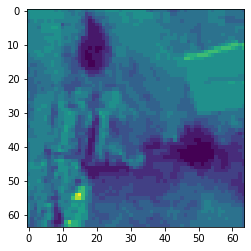

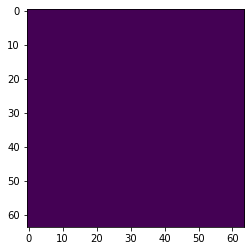

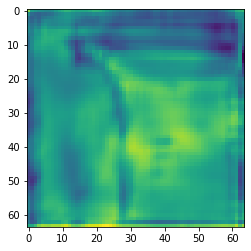

In [23]:
i = 2
img, mask = next(iter(val_loader))
plt.figure()
plt.imshow(img[i][3])
plt.figure()
plt.imshow(mask[i])
pred = model(img.to(device).float())
plt.figure()
plt.imshow(pred[i][1].cpu().detach())

In [17]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

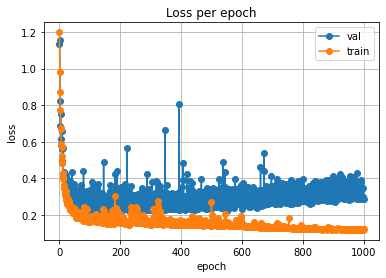

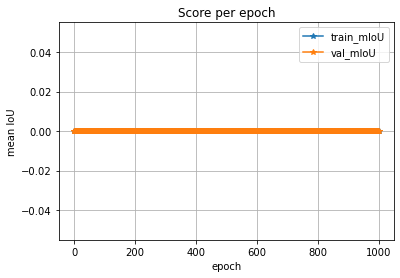

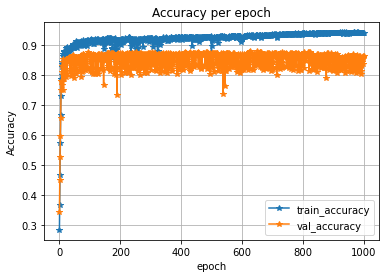

In [18]:
plot_loss(history)
plot_score(history)
plot_acc(history)

# Evaluation

In [19]:
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).float()
        
        return img, mask


t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

NameError: name 'IMAGE_PATH' is not defined

## Result

In [ ]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [ ]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [ ]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [ ]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [ ]:
mob_miou = miou_score(model, test_set)

In [ ]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [ ]:
mob_acc = pixel_acc(model, test_set)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

In [ ]:
image2, mask2 = test_set[4]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

In [ ]:
image3, mask3 = test_set[6]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

In [ ]:
print('Test Set mIoU', np.mean(mob_miou))

In [ ]:
print('Test Set Pixel Accuracy', np.mean(mob_acc))